# Two Part Draft Model
In order to overcome the right-censored nature of NBA draft data, I'm going to make a two part model:

1. Will you be drafted or signed by an NBA team? 
2. If so, how good will you be during your peak?

This idea is not mine. Credit goes to Nick Restifo, who was the first I saw using this method. 

## Import Data
Data is from RealGM.

In [89]:
#load packages
import sys #access to system parameters https://docs.python.org/3/library/sys.html
print("Python version: {}". format(sys.version))

import pandas as pd #collection of functions for data processing and analysis modeled after R dataframes with SQL like features
print("pandas version: {}". format(pd.__version__))

import matplotlib #collection of functions for scientific and publication-ready visualization
print("matplotlib version: {}". format(matplotlib.__version__))

import numpy as np #foundational package for scientific computing
print("NumPy version: {}". format(np.__version__))

import scipy as sp #collection of functions for scientific computing and advance mathematics
print("SciPy version: {}". format(sp.__version__)) 

import IPython
from IPython import display #pretty printing of dataframes in Jupyter notebook
print("IPython version: {}". format(IPython.__version__)) 

import sklearn #collection of machine learning algorithms
print("scikit-learn version: {}". format(sklearn.__version__))

#misc libraries
import random
import time


#ignore warnings
import warnings
warnings.filterwarnings('ignore')
print('-'*25)


Python version: 3.6.4 |Anaconda, Inc.| (default, Jan 16 2018, 10:22:32) [MSC v.1900 64 bit (AMD64)]
pandas version: 0.22.0
matplotlib version: 2.1.1
NumPy version: 1.12.1
SciPy version: 1.0.0
IPython version: 6.2.1
scikit-learn version: 0.19.1
-------------------------


In [90]:
#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.tools.plotting import scatter_matrix

#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

In [91]:
# Make all columns in dataframe output visible
pd.options.display.max_columns = 999

# import data
totals = pd.DataFrame(pd.read_csv('NCAA Player Stats - Totals.csv'))
advanced = pd.DataFrame(pd.read_csv('NCAA Player Stats - Advanced.csv'))
all_player_info = pd.DataFrame(pd.read_csv('RealGM PlayerInfo.csv'))
rsci = pd.DataFrame(pd.read_csv('RSCI.csv'))
tm_pace = pd.DataFrame(pd.read_csv('TeamPace.csv'))
drafted = pd.DataFrame(pd.read_csv('College Players who logged stats in NBA.csv'))
nba = pd.DataFrame(pd.read_csv('Seasons_Stats.csv'))

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# check data import
dfs = {'TOTALS' : totals, 
       'ADVANCED': advanced, 
       'ALL PLAYER INFO': all_player_info, 
       'RSCI': rsci, 
       'NBA': nba}
for df in dfs:
    print(df)
    print(dfs[df].info())
    print('\n')
    print('-'*30)
    

TOTALS
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103530 entries, 0 to 103529
Data columns (total 35 columns):
Player Name          103530 non-null object
Player ID            103530 non-null object
2Y Season            103530 non-null object
Player Season Num    103530 non-null object
Table                103530 non-null object
League               103530 non-null object
Conference           103530 non-null object
Team Name            88657 non-null object
Team Num             85801 non-null object
Season               85801 non-null object
Team Polished        85801 non-null object
Class                103530 non-null object
Class w Trans RS     103530 non-null object
Player ID w Class    103530 non-null object
GP                   103530 non-null object
GS                   103530 non-null object
MIN                  103530 non-null object
FGM                  103530 non-null object
FGA                  103530 non-null object
FG%                  103530 non-null object
3PM   

## Data Preparation
Before I begin cleaning, I'll merge the dataframes appropriately.

In [92]:
# Merge totals and advanced
cols_to_merge = advanced.columns.difference(totals.columns).tolist()
df = pd.merge(totals, advanced[cols_to_merge], left_index=True, right_index=True, how='outer')

# Merge player info onto general stats df from last step.
df = pd.merge(df, all_player_info, on='Player ID', how='left')


### Merge RSCI rankings into df.
# There are multiple players in df with the same name as some of the players in RSCI. To avoid giving the wrong players a RSCI
# ranking, I will merge on the players' names and their assumed first college season with an intermidiate dataframe.

# Because 'Season' column in df is missing values, I'll make my own 'Season' column by manipulating '2Y Season'.
df.drop('Season', axis=1, inplace=True)
df['Season'] = pd.to_numeric(df['2Y Season'].str[0:2] + df['2Y Season'].str[-2:])
df['Season'].replace(1900, 2000, inplace=True)

# Create 'Season' column in rsci from 'Year' string. Add 1
rsci['Season'] = pd.to_numeric(rsci['Year'].str.split('/').str[-2]) + 1

# Create 'Player Name' column in rsci from 'Player'.
rsci['Player Name'] = rsci['Player'].str.strip()

# Intermediate dataframe.
interm_df = df[['Player Name', 'Player ID', 'Season']]
interm_df = interm_df.groupby('Player ID').first().reset_index()
interm_df = interm_df.merge(rsci[['Player Name', 'Season', 'RSCI']], 
                            how='left', on=['Player Name', 'Season'])

# add RSCI data to main dataframe, df.
df = pd.merge(df, interm_df[['Player ID', 'RSCI']], how='left', on='Player ID')


### Merge Team Pace data with df.
# Prep Team Pace data for pace-adjusting.
pace = pd.DataFrame(pd.read_csv('TeamPace.csv'))


pace['Team'] = pace['Team'].str.replace('\s+', '-')
pace['Team'] = pace['Team'].str.replace("\(|\)|\.|\;|'|&", '')
pace['Team'] = pace['Team'].str.replace("Lafayette-", "Lafayette")
pace['Team'] = pace['Team'].str.replace("Monroe-", "Monroe")
pace['Team'] = pace['Team'].str.replace("Arkansas-State-", "Arkansas-State")
pace['Team'] = pace['Team'].str.replace("Florida-Atlantic-", "Florida-Atlantic")
pace['Team'] = pace['Team'].str.replace("Arkansas-Pine-Bluff-", "Arkansas-Pine-Bluff")
pace['Team'] = pace['Team'].str.replace("Tennessee-Tech-", "Tennessee-Tech")
pace['Team'] = pace['Team'].str.replace("Detroit-Mercy", "Detroit")
pace['Team'] = pace['Team'].str.replace("Alabama-AM-", "Alabama-AM")
pace['Team'] = pace['Team'].str.replace("Pennsylvania-", "Pennsylvania")
pace['Team'] = pace['Team'].str.replace("William--Mary", "William-Mary")
# Some teams have specific issues. There were only 10, I did them manually.

pace['Team Name'] = pace['Team']
pace.drop('Team', axis=1, inplace=True)

# merge pace data into df.
df = df.merge(pace, how='left', on=['Team Name', 'Season'])

I'll now add the first target variable: did he make the NBA?


In [93]:
### Add Target variable from drafted_signed dataframe. 
# make column for drafted_signed df; played anytime in NBA ever=1, never played in NBA=0 (a decent proxy for drafted or signed)
drafted['Drafted'] = 1

# merge 'drafted' into df
df = df.merge(drafted, how='left', on='Player ID')

# fill missing 'drafted' with 0.
df['Drafted'].fillna(0, inplace=True)

## Cleaning
I'll begin deleting unwanted columns, formating columns and filling missing values where necessary.

In [94]:
# drop unwanted columns 
col_drop = ['2Y Season', 'Table', 'League', 'Conference', 'Team Name', 'Team Num', 'Team Polished', 
            'Class', 'Player ID w Class', 'Status', 'Team w Stuff', 'Name', 'School (college)', 'Birthday Text', 
            'Hometown', 'High School']
df.drop(col_drop, axis=1, inplace=True)

In [95]:
df.columns


Index(['Player Name', 'Player ID', 'Player Season Num', 'Class w Trans RS',
       'GP', 'GS', 'MIN', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', 'FTM',
       'FTA', 'FT%', 'OFF', 'DEF', 'TRB', 'AST', 'STL', 'BLK', 'PF', 'TOV',
       'PTS', 'AST%', 'BLK%', 'DRB%', 'DRtg', 'ORB%', 'ORtg', 'PER', 'PPR',
       'PPS', 'STL%', 'TOV%', 'TRB%', 'TS%', 'Total S %', 'USG%', 'eFG%',
       'Position', 'Height', 'Weight', 'Birthday Code', 'Season', 'RSCI',
       'Pace', 'Drafted'],
      dtype='object')

### Collegiate Class

In [96]:
### What to do with Class?
df['Class'] = df['Class w Trans RS']
df.drop('Class w Trans RS', axis=1, inplace=True)

# Class attribute distribution:
df['Class'].value_counts()

Fr                 30180
So                 25820
Jr                 21759
Sr                 17041
Trans               3285
RS-Fr               3040
RS-So               1005
RS-Jr                810
RS-Sr                559
Fr (Ineligible)       23
Jr (Ineligible)        8
Sr (Ineligible)        3
So (Ineligible)        2
Name: Class, dtype: int64

In [97]:
# Remove 'Trans' and all '(Ineligible)' values.
rmv_class_values = ['Trans', 'Fr (Ineligible)', 'So (Ineligible)', 'Jr (Ineligible)', 'Sr (Ineligible)']
df = df[-df['Class'].isin(rmv_class_values)]

### Column Data Types
I'll convert continuous statistical attributes to a numerical data type.

In [98]:
# Convert numeric columns to a numeric data type.
continuous_cols = ['GP', 'GS', 'MIN','FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OFF', 'DEF', 'TRB', 'AST', 
                   'STL', 'BLK', 'PF', 'TOV', 'PTS', 'AST%', 'BLK%', 'DRB%', 'DRtg', 'ORB%', 'ORtg', 'PER', 'PPR', 'PPS', 'STL%',
                   'TOV%', 'TRB%', 'TS%', 'Total S %', 'USG%', 'eFG%']
for column in continuous_cols:
    df[column] = pd.to_numeric(df[column], errors='coerce')

### Positions
I'll map all the positions onto four values: point guard (PG), guard (G), wing (W), big (B).


In [99]:
# Current values of 'Position' attribute.
df['Position'].unique()

array(['G', 'C', 'PG', 'GF', 'SG', 'F', 'F-G', nan, 'PF', 'FC', 'SF',
       'F-C', 'G-F', 'C-F'], dtype=object)

In [100]:
# Map old positions to new positions and create new positions column.
point_guard = ['PG']
guards = ['G', 'SG']
wings = ['GF', 'F-G', 'SF', 'G-F']
bigs = ['F', 'PF', 'FC', 'F-C', 'C-F', 'C']

df['temp_pos'] = np.where(df['Position'].isin(point_guard), 'PG',
                         np.where(df['Position'].isin(guards), 'G',
                                 np.where(df['Position'].isin(wings), 'W',
                                         np.where(df['Position'].isin(bigs), 'B', None))))
df.drop('Position', axis=1, inplace=True)
df['Position'] = df['temp_pos']
df.drop('temp_pos', axis=1, inplace=True)

# Drop players without a position.
df = df[pd.notnull(df['Position'])]

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99630 entries, 0 to 103534
Data columns (total 49 columns):
Player Name          99630 non-null object
Player ID            99630 non-null object
Player Season Num    99630 non-null object
GP                   72280 non-null float64
GS                   72280 non-null float64
MIN                  72280 non-null float64
FGM                  72280 non-null float64
FGA                  68642 non-null float64
FG%                  72280 non-null float64
3PM                  72280 non-null float64
3PA                  72280 non-null float64
3P%                  72280 non-null float64
FTM                  72280 non-null float64
FTA                  72280 non-null float64
FT%                  72280 non-null float64
OFF                  72280 non-null float64
DEF                  72280 non-null float64
TRB                  72280 non-null float64
AST                  72280 non-null float64
STL                  72280 non-null float64
BLK          

### Height
I want to convert ft-inches str of current Height column to height in inches, and replace missing values of Height with average values based on positions.

In [102]:
# Make temporary dataframe with height and position data.
ht_pos_df = df[['Height', 'Position']]

# Remove NANs and '-' values.
ht_pos_df = ht_pos_df[ht_pos_df['Height'] != '-']
ht_pos_df.dropna(axis=0, how='any', inplace=True)

# Make numeric height column in inches.
ht_pos_df['height_inches'] = pd.to_numeric(ht_pos_df['Height'].str[0]) * 12 + pd.to_numeric(ht_pos_df['Height'].str.split('-').str[1])
ht_pos_df.drop('Height', axis=1, inplace=True)

In [103]:
# Find average height by position.
pos_ht_mean = ht_pos_df.groupby('Position').mean()
pos_ht_mean

,height_inches
Position,
B,79.912364
G,74.247489
PG,72.186659
W,77.687597


In [104]:
# Replace '-' in Height column of df.
df['Height'].replace('-', np.nan, inplace=True)


# Convert hieght to inches.
df['height_inches'] = pd.to_numeric(
    df['Height'].str[0]) * 12 + pd.to_numeric(
    df['Height'].str.split('-').str[1])

In [105]:
# Make dictionary of height averages by position.
pos_ht_dict = pos_ht_mean.to_dict()['height_inches']

# Fill NANs in height column with position averages from pos_ht_mean dataframe.
df['filled_ht'] = np.where(np.isfinite(df['height_inches']), df['height_inches'],
                           np.where(df['Position'] == 'B', pos_ht_dict['B'],
                                   np.where(df['Position'] == 'G', pos_ht_dict['G'],
                                           np.where(df['Position'] == 'PG', pos_ht_dict['PG'],
                                                   np.where(df['Position'] == 'W', pos_ht_dict['W'], None)))))

# Drop unccessary height cols and rename filled col.
df.drop(['height_inches', 'Height'], axis=1, inplace=True)
df['Height'] = df['filled_ht']
df.drop('filled_ht', axis=1, inplace=True)

# Convert Height to numeric data type.
df['Height'] = pd.to_numeric(df['Height'])

### Age
I'll convert the Birthday Code (str) column into Age on Jan 1. of that season. I'll fill in missing ages with average age of season number.

In [106]:
# Get rid of '-' in column.
df['Birthday Code'].replace('-', np.nan, inplace=True)

# Get age from Birthday Code.
df['Age'] = (df['Season'] - pd.to_numeric(
    df['Birthday Code'].str[:4])) - ((((pd.to_numeric(
    df['Birthday Code'].str[4:6]) - 1) * 30.4375) + pd.to_numeric(
    df['Birthday Code'].str[6:])) / 365.25)

# To fill in missing ages, give first season the average age of all first year players, and so on.
df['season_num'] = pd.to_numeric(
    df['Player Season Num'].str.split('_').str[3].str[:-1]).astype(int)

for num in range(1, 11):
    num_age_mean = df[df['season_num'] == num]['Age'].mean()
    df.loc[df.season_num == num, 'Age'] = df.loc[
        df.season_num == num, 'Age'].fillna(num_age_mean)
    
# Drop birthday code and season_num.
df.drop(['Birthday Code', 'season_num', 'Player Season Num'], axis=1, inplace=True)

There are some wacky ages (as young as 10!). I'll keep players who are at least 18 during their first season, and 24 in their fourth. We might cut off some quality data, but for the most part these players are not representative of the players who will enter the NBA and they will skew our age adjustments later.

In [107]:
# List of player ids who are too young and too old.
young_plyrids = df[df['Age'] < 18]['Player ID'].tolist()
old_plyrids = df[df['Age'] > 25]['Player ID'].tolist()

rmv_playerids = young_plyrids + old_plyrids

# Remove players in above lists from dataframe.
df = df[~df['Player ID'].isin(rmv_playerids)]

### Minutes
I'll remove seasons where 0 minutes were played. 

In [108]:
print(df.shape)
df = df[np.isfinite(df['MIN'])]
df = df[df['MIN'] > 0]
print(df.shape)

(97583, 48)
(70947, 48)


### Missing Rate Stats
Some rate statistics are missing and I believe due to a lack of data from non-D1 programs, or similarly small programs. I could try to predict these statistics based on averages and the player's rate stats from other seasons, but that is time consuming and possibly a huge waste of time. I'll simply remove players that have missing rate statistics.

In [109]:
# List of player ids that have missing rates in any season.
playerids_missing_rates = df[~np.isfinite(df['AST%'])]['Player ID'].tolist()

# Remove players in above list from dataframe.
df = df[-df['Player ID'].isin(playerids_missing_rates)]


In [110]:
df.shape

(64210, 48)

### Missing FGA
I'll fill missing FGA with 0.

In [111]:
df['FGA'].fillna(0, inplace=True)
df.shape

(64210, 48)

### Missing ORB%
Unfortunately ORB% data wasn't aquired correctly. I'll remove ORB% from df.

In [112]:
df.drop('ORB%', axis=1, inplace=True)
df.shape

(64210, 47)

### Missing Weight
I'll remove players with missing weight.

In [113]:
df = df[pd.notnull(df['Weight'])]
df.shape

(64108, 47)

### Missing RSCI
I'll simlpy fill missing values with 1 + max RSCI value. (This isn't the ideal way to present the data to the algorithms, but I'll get to that when I feature engineer a little.)

In [114]:
# Find rsci max value.
rsci_max = df['RSCI'].max()

# Fill with maxRSCI + 1.
df['RSCI'].fillna(rsci_max + 1, inplace=True)
df.shape

(64108, 47)

In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64108 entries, 1 to 103530
Data columns (total 47 columns):
Player Name    64108 non-null object
Player ID      64108 non-null object
GP             64108 non-null float64
GS             64108 non-null float64
MIN            64108 non-null float64
FGM            64108 non-null float64
FGA            64108 non-null float64
FG%            64108 non-null float64
3PM            64108 non-null float64
3PA            64108 non-null float64
3P%            64108 non-null float64
FTM            64108 non-null float64
FTA            64108 non-null float64
FT%            64108 non-null float64
OFF            64108 non-null float64
DEF            64108 non-null float64
TRB            64108 non-null float64
AST            64108 non-null float64
STL            64108 non-null float64
BLK            64108 non-null float64
PF             64108 non-null float64
TOV            64108 non-null float64
PTS            64108 non-null float64
AST%           641

In [116]:
df['min_poss'] = 40 / df['Pace']
df.columns

Index(['Player Name', 'Player ID', 'GP', 'GS', 'MIN', 'FGM', 'FGA', 'FG%',
       '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OFF', 'DEF', 'TRB', 'AST',
       'STL', 'BLK', 'PF', 'TOV', 'PTS', 'AST%', 'BLK%', 'DRB%', 'DRtg',
       'ORtg', 'PER', 'PPR', 'PPS', 'STL%', 'TOV%', 'TRB%', 'TS%', 'Total S %',
       'USG%', 'eFG%', 'Weight', 'Season', 'RSCI', 'Pace', 'Drafted', 'Class',
       'Position', 'Height', 'Age', 'min_poss'],
      dtype='object')

## Pace Adjustments
Using 'Pace' I will turn season totals (FGM, FGA, TRB, STL...) into per 100 possession statitsitcs.

(I'll assume that PER, PPR, PPS are already pace adjusted.)

In [117]:
# Pace is Possessions per Game. Turn that into minutes per possession.
df['min_poss'] = 40 / df['Pace']

# Adjust away!
cols_pace_adj = ['FGM', 'FGA', '3PM', '3PA', 'FTM', 'FTA', 'OFF', 'DEF', 'TRB', 'AST', 'STL', 'BLK', 'PF', 'TOV', 'PTS',]

for col in cols_pace_adj:
    df[col + '_per100poss'] = ((df[col] / df['MIN']) * df['min_poss']) * 100  

In [118]:
df.columns

Index(['Player Name', 'Player ID', 'GP', 'GS', 'MIN', 'FGM', 'FGA', 'FG%',
       '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OFF', 'DEF', 'TRB', 'AST',
       'STL', 'BLK', 'PF', 'TOV', 'PTS', 'AST%', 'BLK%', 'DRB%', 'DRtg',
       'ORtg', 'PER', 'PPR', 'PPS', 'STL%', 'TOV%', 'TRB%', 'TS%', 'Total S %',
       'USG%', 'eFG%', 'Weight', 'Season', 'RSCI', 'Pace', 'Drafted', 'Class',
       'Position', 'Height', 'Age', 'min_poss', 'FGM_per100poss',
       'FGA_per100poss', '3PM_per100poss', '3PA_per100poss', 'FTM_per100poss',
       'FTA_per100poss', 'OFF_per100poss', 'DEF_per100poss', 'TRB_per100poss',
       'AST_per100poss', 'STL_per100poss', 'BLK_per100poss', 'PF_per100poss',
       'TOV_per100poss', 'PTS_per100poss'],
      dtype='object')

In [119]:
df.isnull().sum()

Player Name       0
Player ID         0
GP                0
GS                0
MIN               0
FGM               0
FGA               0
FG%               0
3PM               0
3PA               0
3P%               0
FTM               0
FTA               0
FT%               0
OFF               0
DEF               0
TRB               0
AST               0
STL               0
BLK               0
PF                0
TOV               0
PTS               0
AST%              0
BLK%              0
DRB%              0
DRtg              0
ORtg              0
PER               0
PPR               0
                 ..
TRB%              0
TS%               0
Total S %         0
USG%              0
eFG%              0
Weight            0
Season            0
RSCI              0
Pace              0
Drafted           0
Class             0
Position          0
Height            0
Age               0
min_poss          0
FGM_per100poss    0
FGA_per100poss    0
3PM_per100poss    0
3PA_per100poss    0


## Age Adjustments
Using simple regression, I'll plot age curves for each statistic by age, then adjust all numbers to a 19 year old's level so they can be averaged.

In [120]:
# import matplot lib for checking regression.
import matplotlib.pyplot as plt

# Make age bins
bins = np.arange(18, 24.25, .25)
age_bins = pd.cut(df['Age'], bins)
mean_age_df = df.groupby(age_bins).mean().dropna()

# Make x axis for age groups. (Mid-point of each bin.)
x_age_groups = np.arange(18.125, 24, 0.25)[2:]

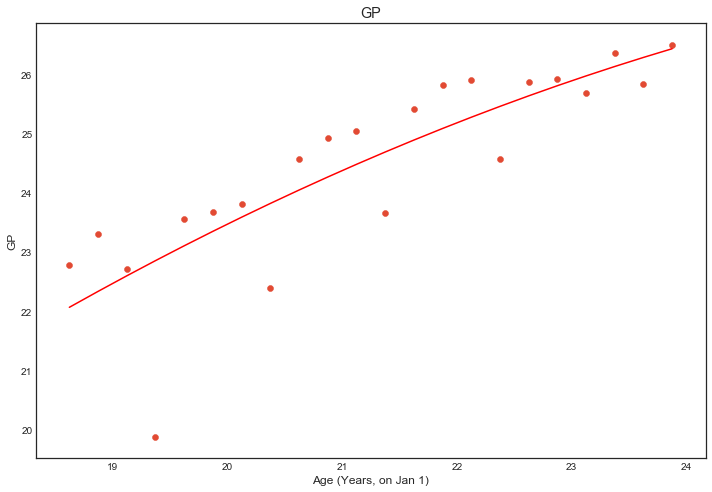

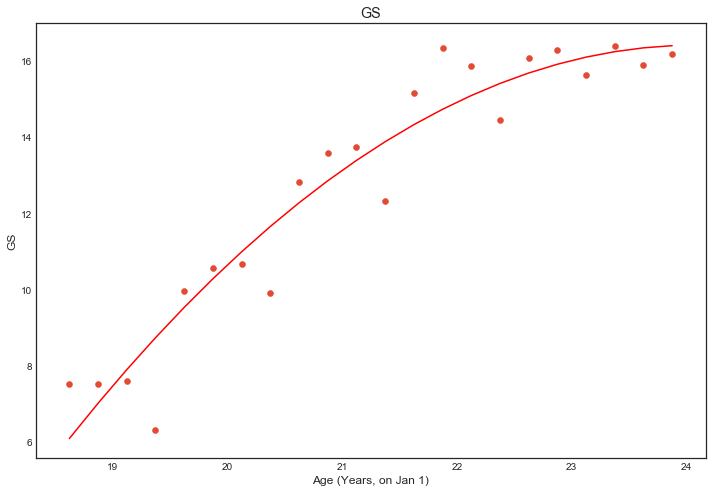

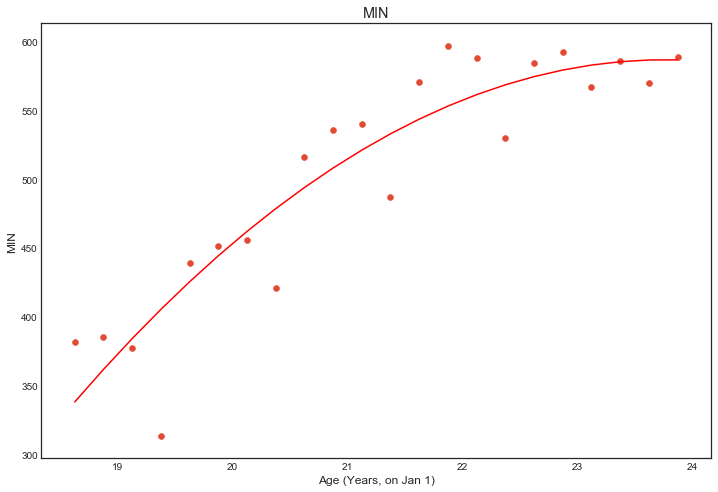

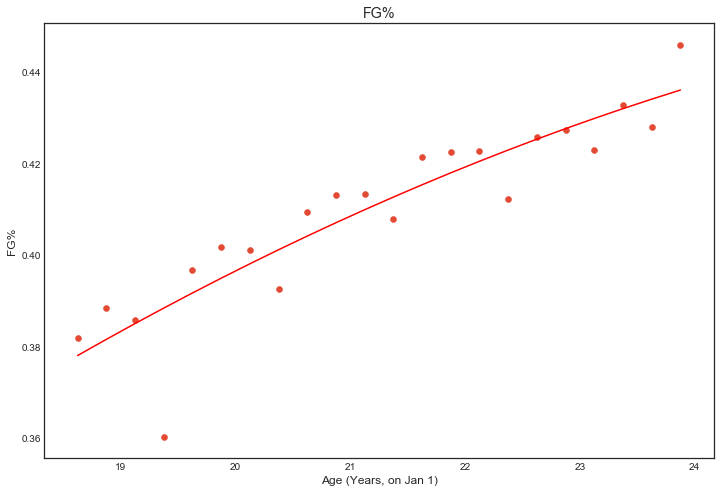

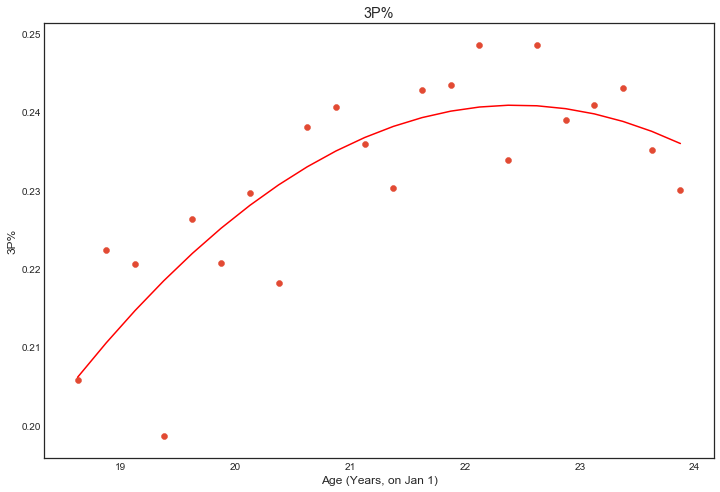

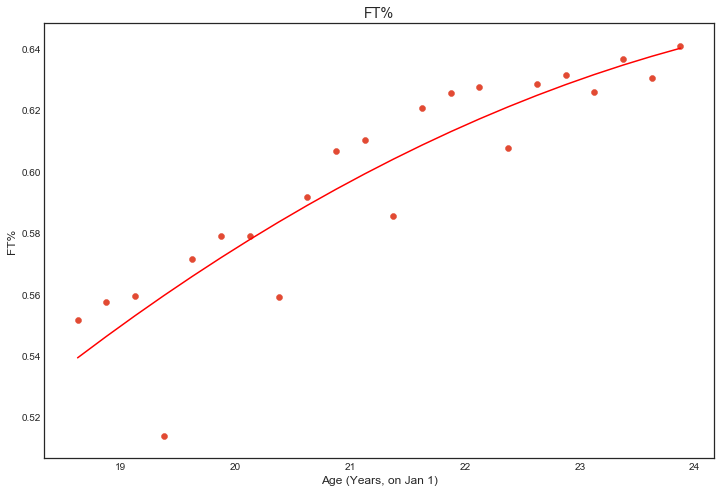

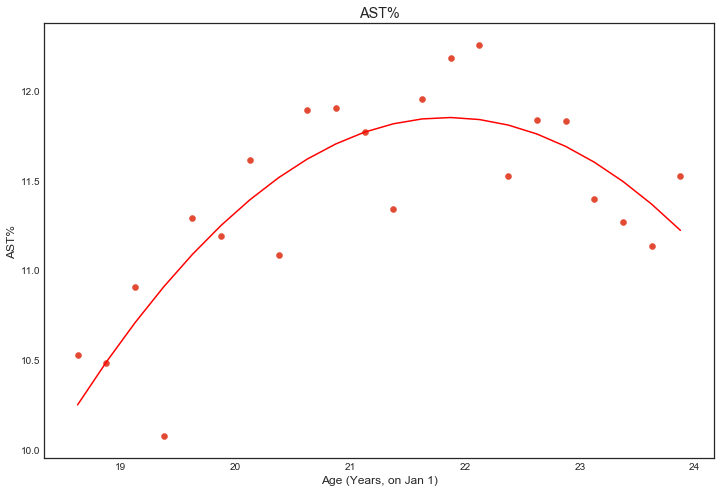

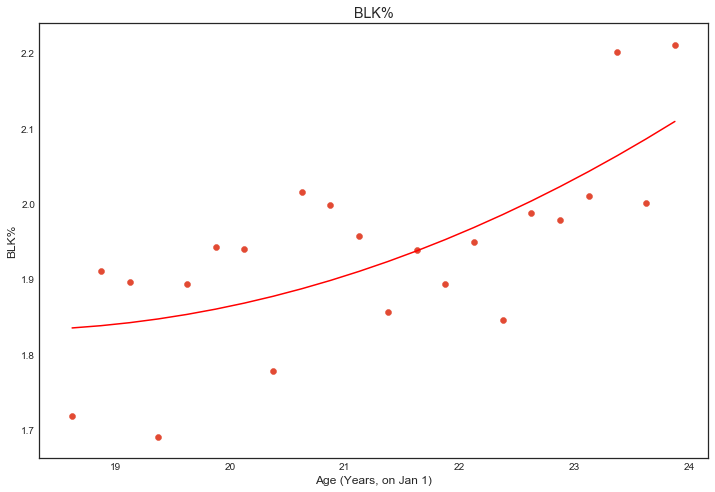

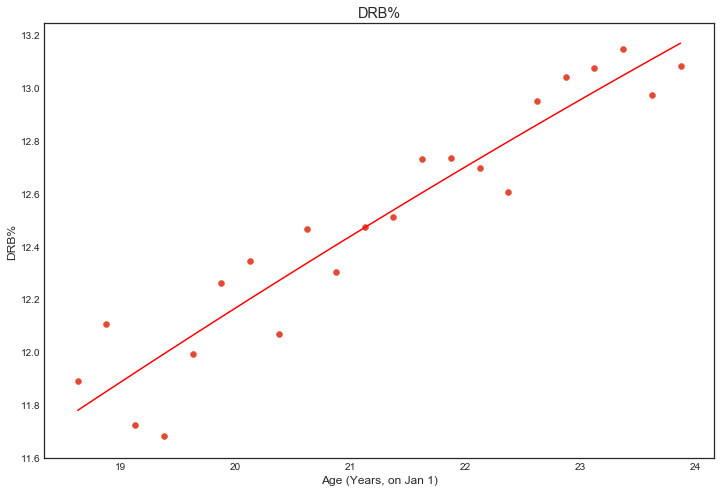

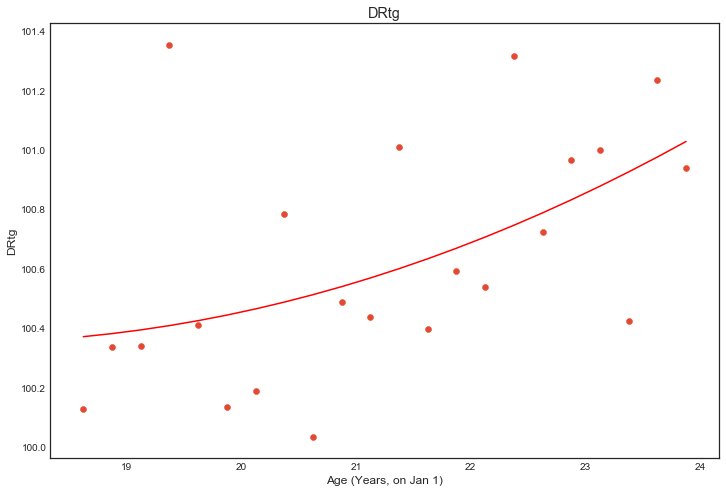

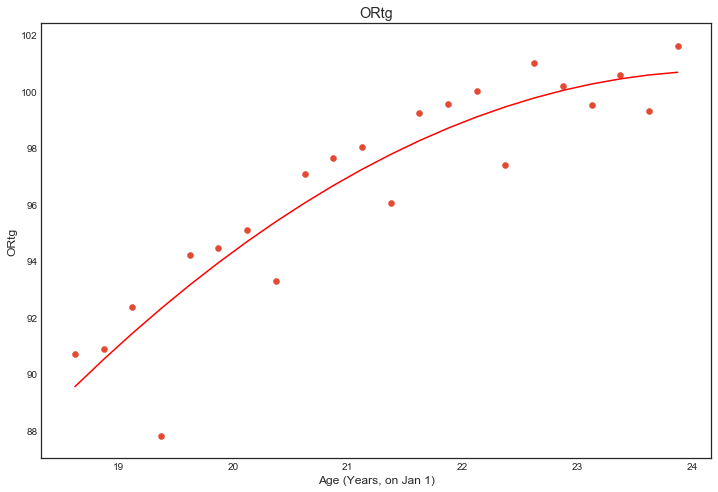

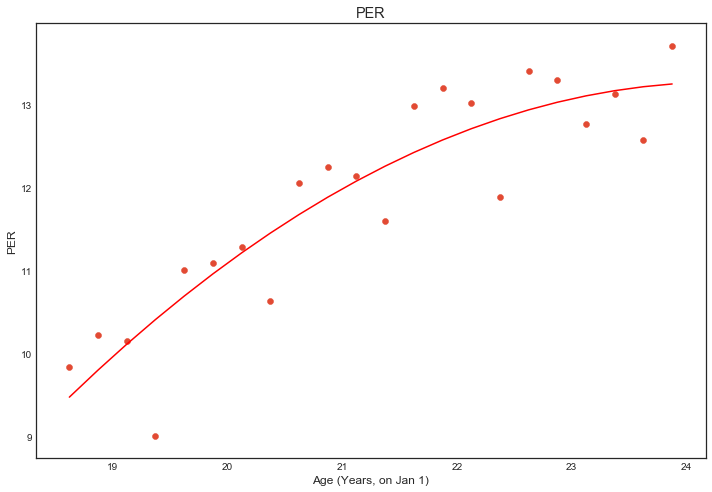

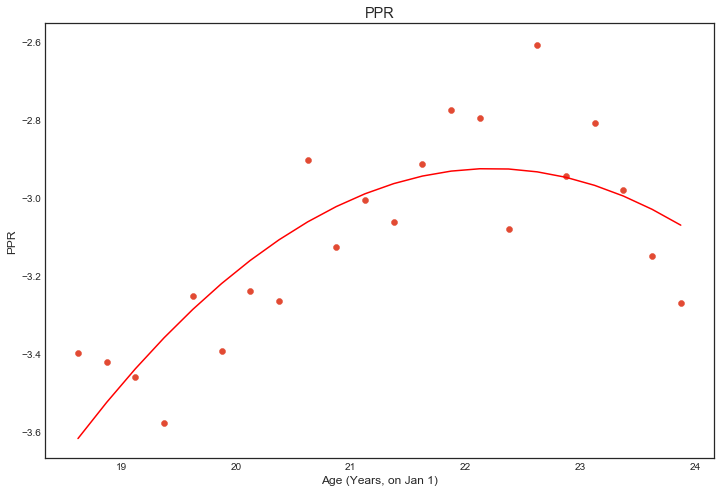

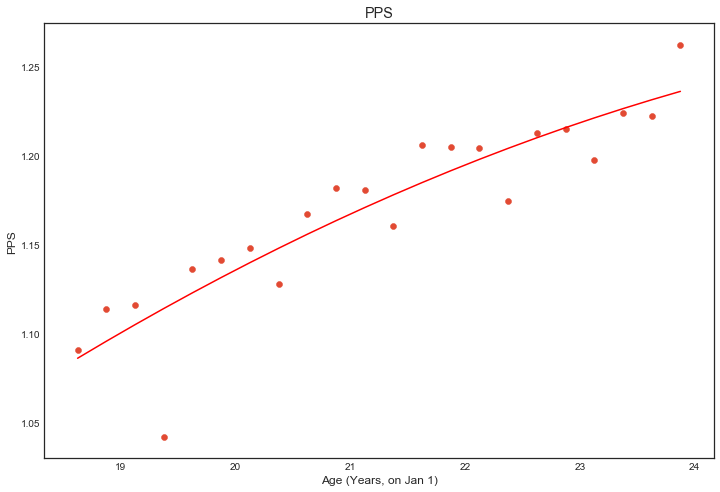

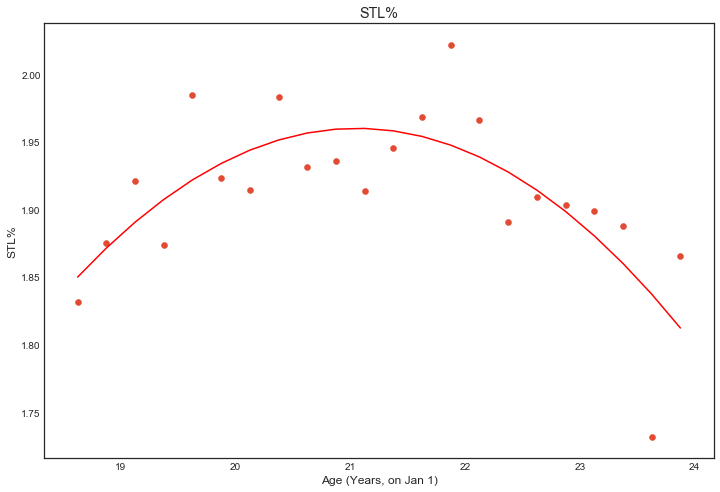

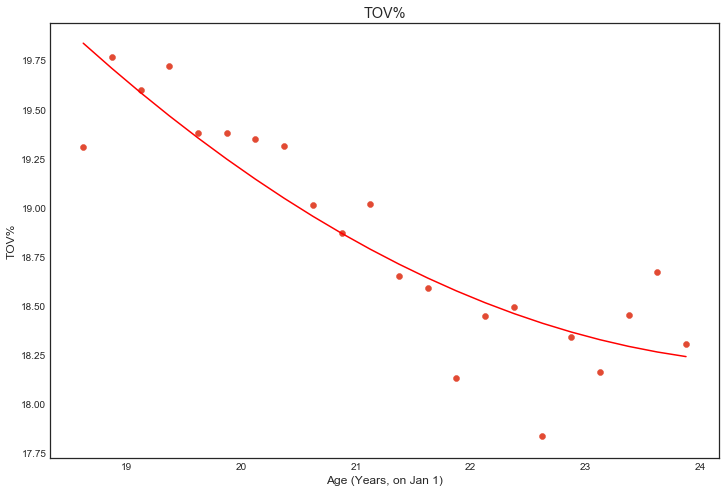

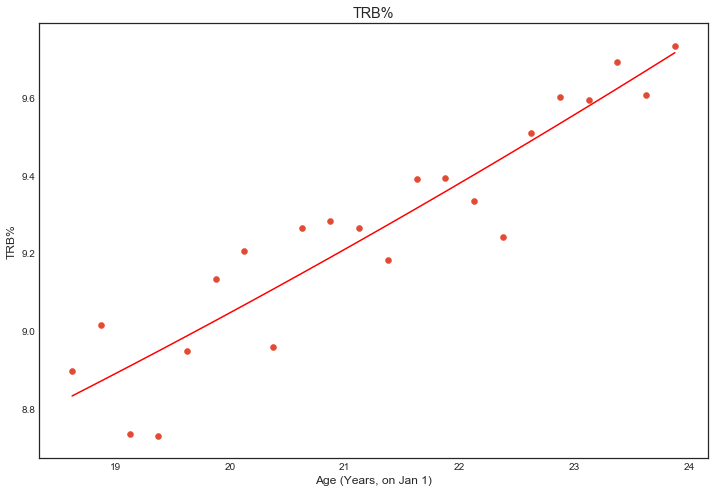

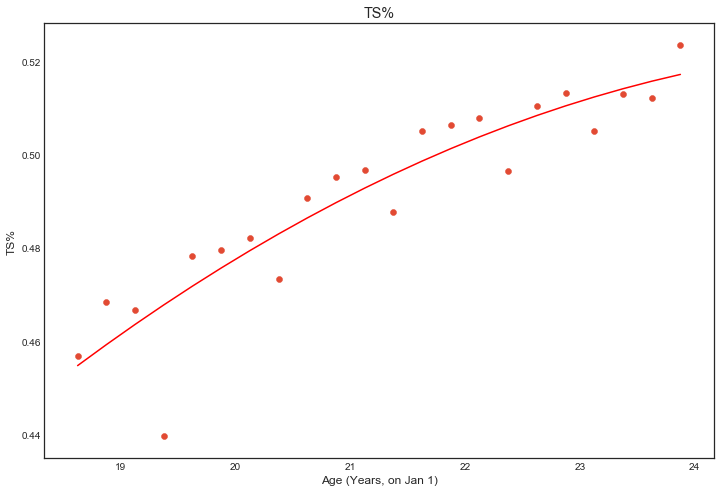

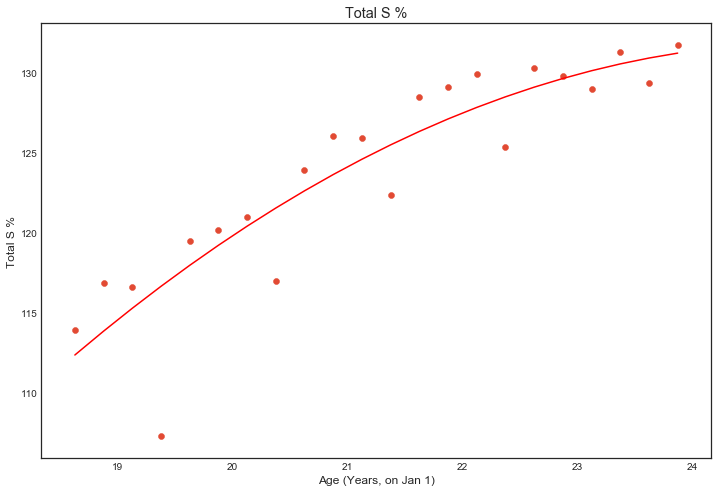

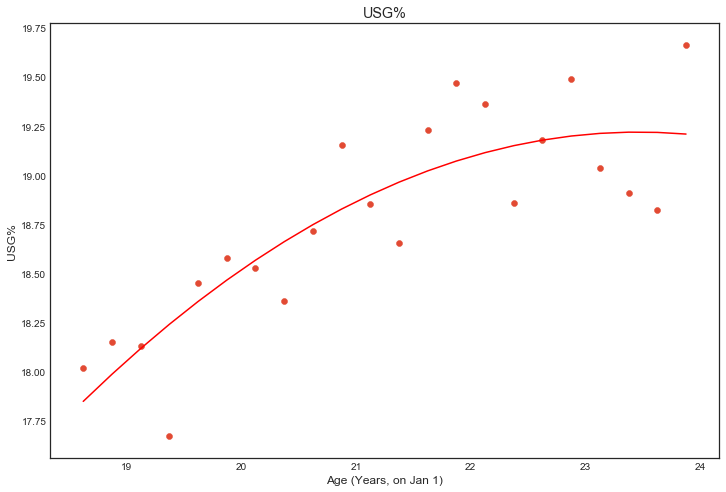

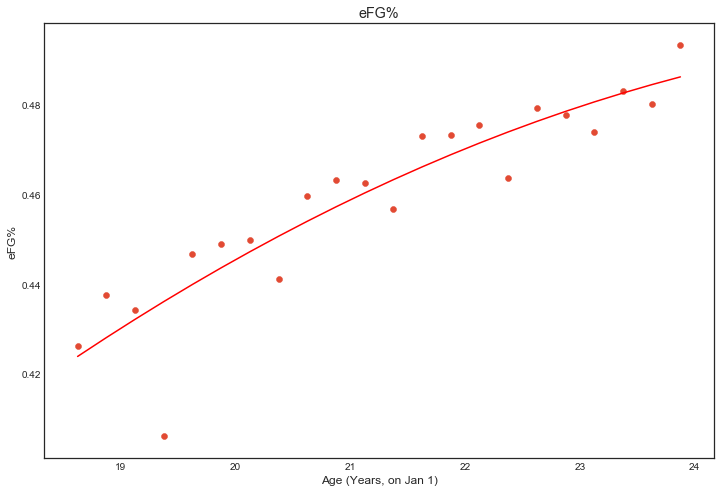

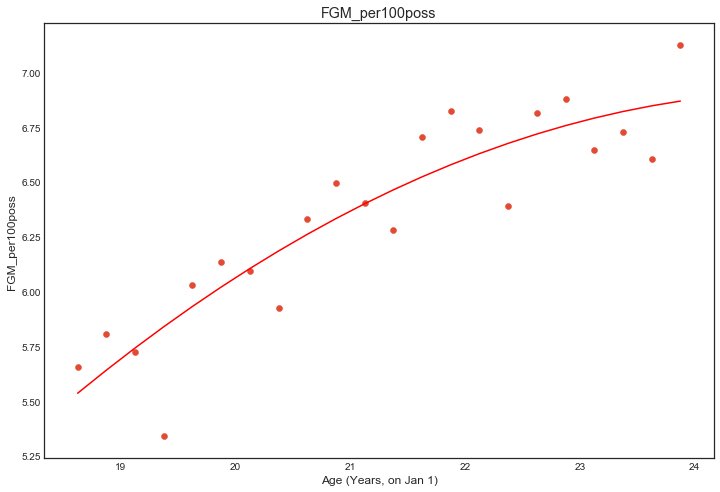

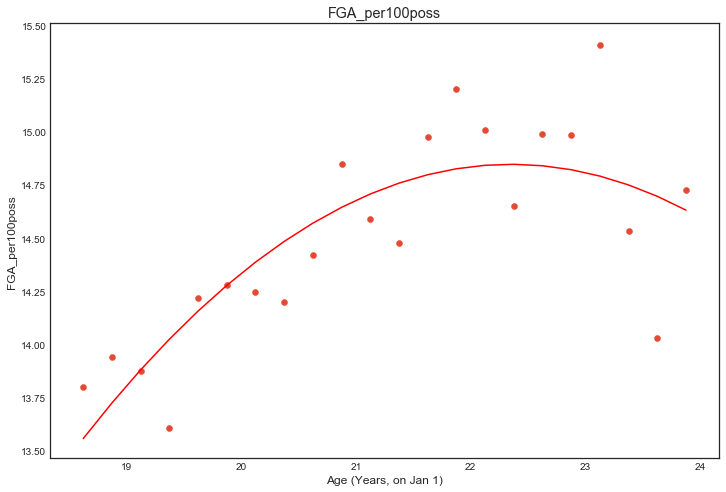

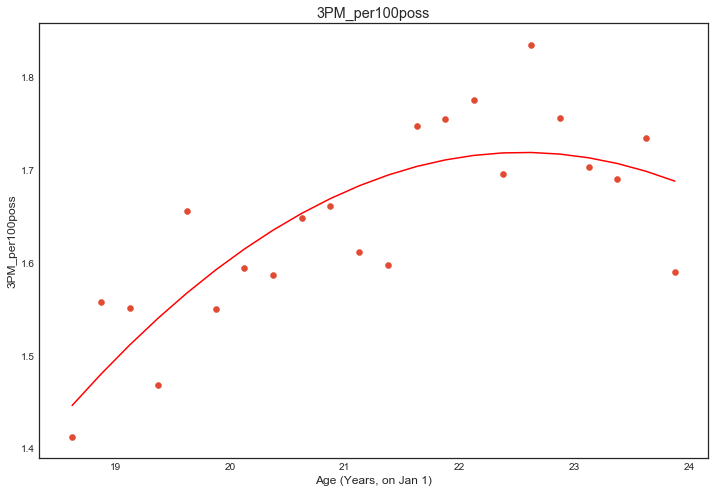

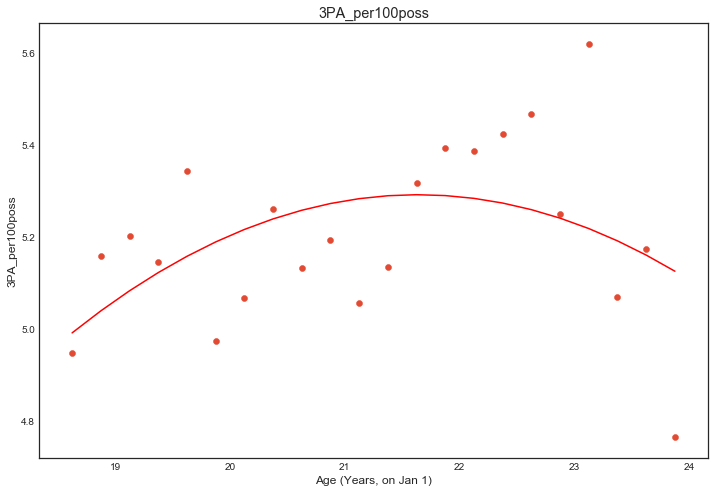

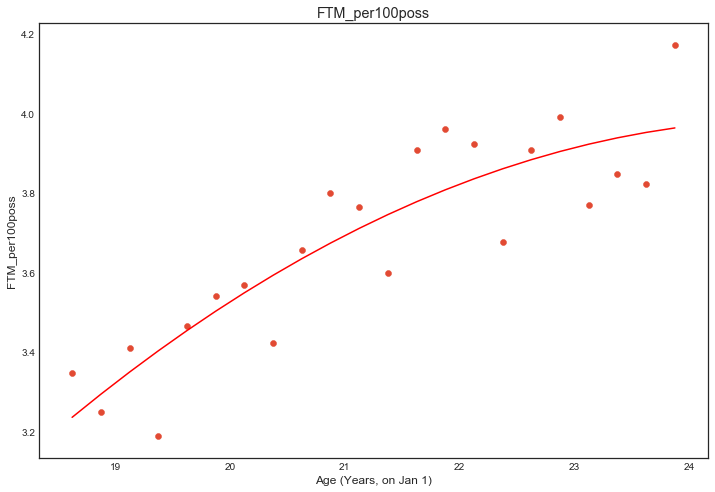

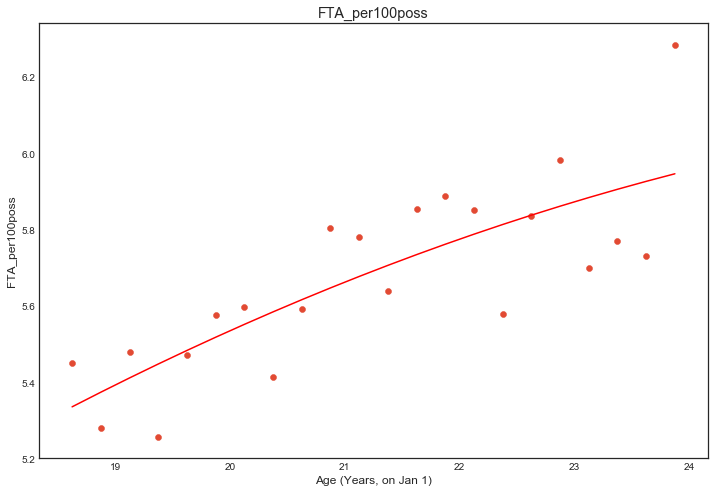

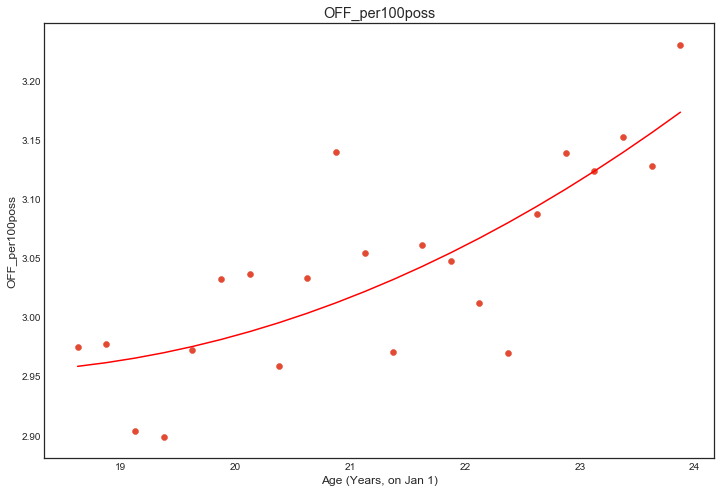

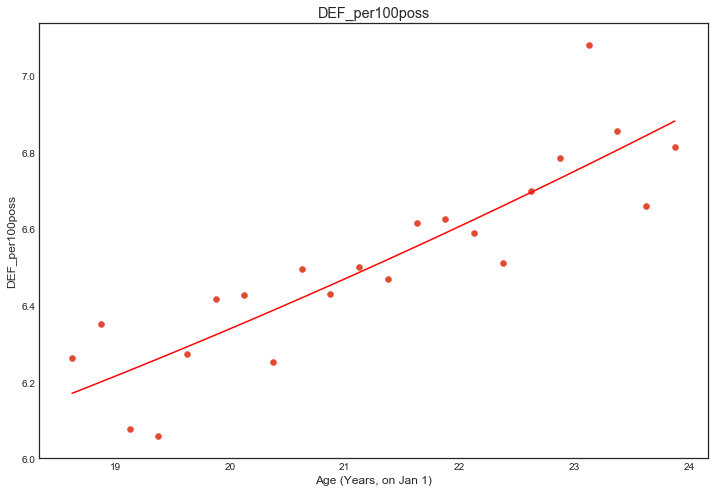

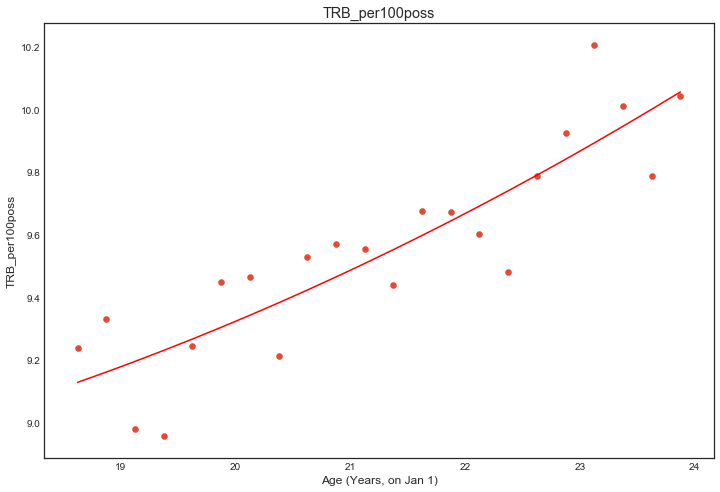

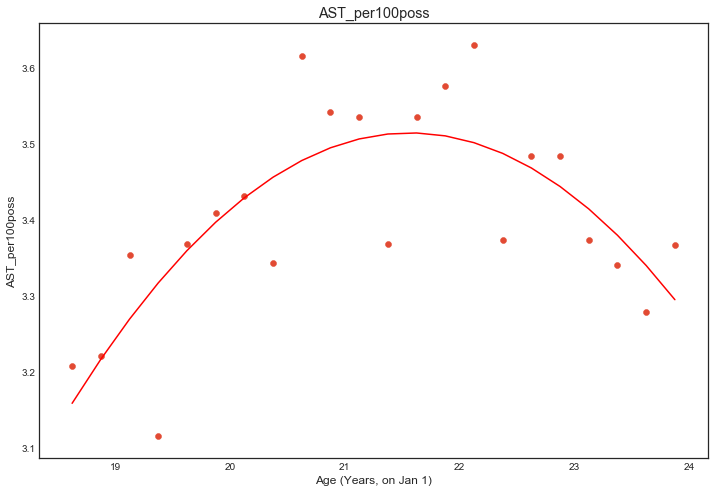

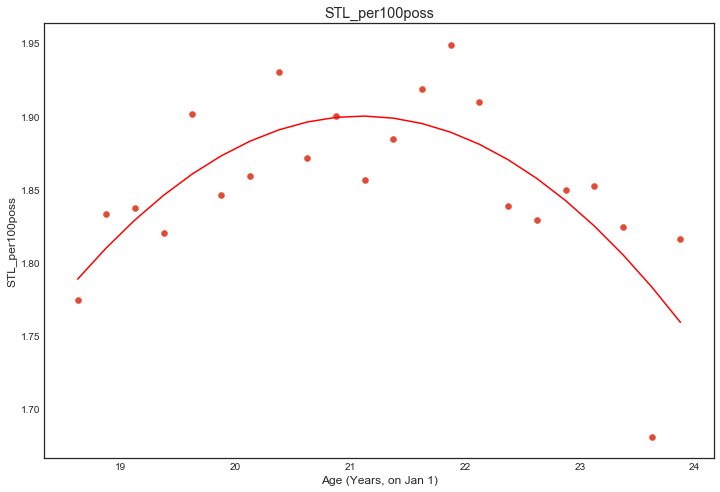

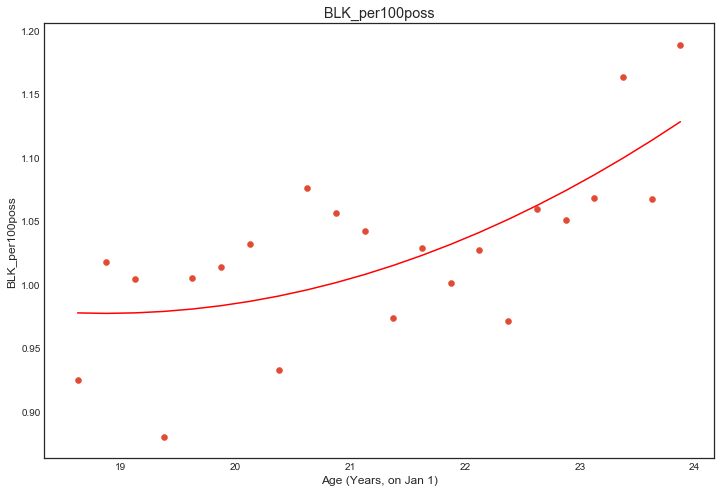

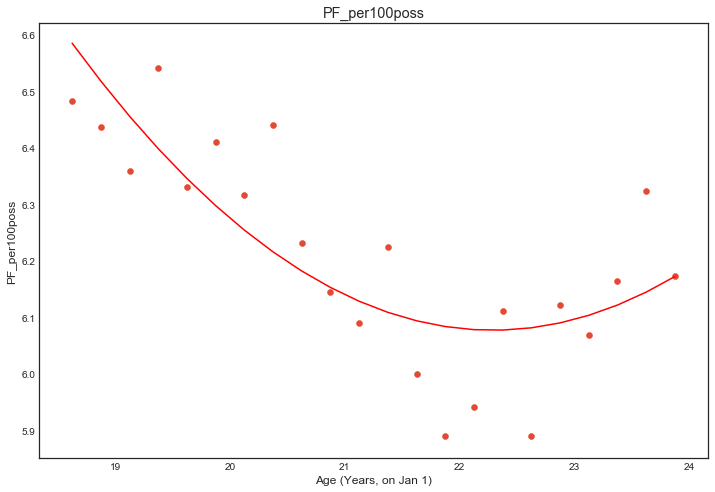

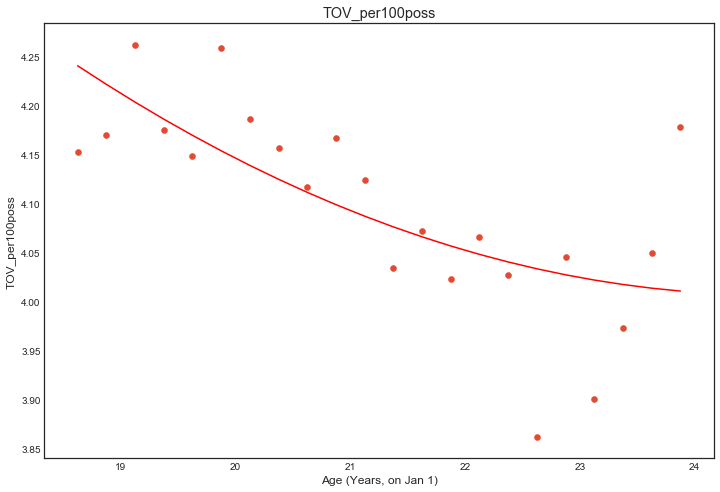

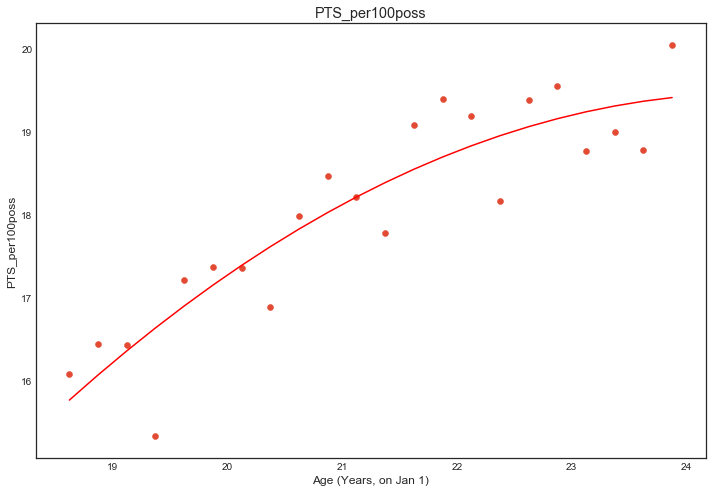

In [121]:
# columns to age adjust:
col_age_adj = ['GP', 'GS', 'MIN', 'FG%', '3P%', 'FT%',
       'AST%', 'BLK%', 'DRB%', 'DRtg', 'ORtg', 'PER', 'PPR', 'PPS', 'STL%',
       'TOV%', 'TRB%', 'TS%', 'Total S %', 'USG%', 'eFG%', 'FGM_per100poss', 'FGA_per100poss', '3PM_per100poss',
       '3PA_per100poss', 'FTM_per100poss', 'FTA_per100poss', 'OFF_per100poss',
       'DEF_per100poss', 'TRB_per100poss', 'AST_per100poss', 'STL_per100poss',
       'BLK_per100poss', 'PF_per100poss', 'TOV_per100poss', 'PTS_per100poss']

## Age ajustments.
# iterate of columns to adjust.
for col in col_age_adj:
    # assign mean values by age bin to y.
    y = np.asarray(mean_age_df[col])[2:]
    
    # plot curve age vs. col mean, and fit curve. (Using quadratic instead of choosing appropriate power for each is good approximation and time saver.)
    fig, ax = plt.subplots()
    fit = np.polyfit(x_age_groups, y, deg=2)
    ax.plot(x_age_groups, fit[0] * x_age_groups ** 2 + fit[1] * x_age_groups + fit[2], color='red')
    ax.scatter(x_age_groups, y)
    plt.xlabel('Age (Years, on Jan 1)')
    plt.ylabel(col)
    plt.title(col)

    fig.show()
    
    #  Create new age-adjusted col. 
    mean_19 = fit[0] * 19 ** 2 + fit[1] * 19 + fit[2]
    df['age_' + col] = (df[col] * mean_19) / (fit[0] * df['Age'] ** 2 + fit[1] * df['Age'] + fit[2])


## Feature Engineering
For now this section is short. I'll start model selection then come back to this to try and improve later.

In [122]:
# Create inverse of RSCI to help model types that are dependent on variable relationships.
df['inv_RSCI'] = (1 / df['RSCI']) * 100

### Finally Time to Combine!
I'll combine stats, that are now pace and age adjusted, by averaging columns where it makes sense to average.

In [86]:
df.reset_index(drop=True, inplace=True)

# Columns to average
cols_to_avg = ['age_GP', 'age_GS', 'age_MIN',
       'age_FG%', 'age_3P%', 'age_FT%', 'age_AST%', 'age_BLK%', 'age_DRB%',
       'age_DRtg', 'age_ORtg', 'age_PER', 'age_PPR', 'age_PPS', 'age_STL%',
       'age_TOV%', 'age_TRB%', 'age_TS%', 'age_Total S %', 'age_USG%',
       'age_eFG%', 'age_FGM_per100poss', 'age_FGA_per100poss',
       'age_3PM_per100poss', 'age_3PA_per100poss', 'age_FTM_per100poss',
       'age_FTA_per100poss', 'age_OFF_per100poss', 'age_DEF_per100poss',
       'age_TRB_per100poss', 'age_AST_per100poss', 'age_STL_per100poss',
       'age_BLK_per100poss', 'age_PF_per100poss', 'age_TOV_per100poss',
       'age_PTS_per100poss']
avg_df = df.groupby('Player ID')[cols_to_avg].mean()

# Columns where final value is best/fine.
cols_last = ['Height', 'Age', 'inv_RSCI', 'Position', 'Drafted']
last_df = df.groupby('Player ID')[cols_last].last()

# # Add dummy variables for Class and Position.
# dummy_class = pd.get_dummies(last_df['Class'])
# df = pd.concat([df, dummy_class], axis=1)

dummy_pos = pd.get_dummies(last_df['Position'], prefix='Pos')
last_df = pd.concat([last_df, dummy_pos], axis=1)
last_df.drop('Position', axis=1, inplace=True)

# Combine avg and last.
df = pd.merge(avg_df, last_df, right_index=True, left_index=True)

In [87]:
df

,age_GP,age_GS,age_MIN,age_FG%,age_3P%,age_FT%,age_AST%,age_BLK%,age_DRB%,age_DRtg,age_ORtg,age_PER,age_PPR,age_PPS,age_STL%,age_TOV%,age_TRB%,age_TS%,age_Total S %,age_USG%,age_eFG%,age_FGM_per100poss,age_FGA_per100poss,age_3PM_per100poss,age_3PA_per100poss,age_FTM_per100poss,age_FTA_per100poss,age_OFF_per100poss,age_DEF_per100poss,age_TRB_per100poss,age_AST_per100poss,age_STL_per100poss,age_BLK_per100poss,age_PF_per100poss,age_TOV_per100poss,age_PTS_per100poss,Height,Age,inv_RSCI,Drafted,Player Name,Pos_B,Pos_G,Pos_PG,Pos_W
Player ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
/AB-Lehmann/Summary/18966,5.895269,0.000000,12.851892,0.493235,0.486292,0.490899,9.156569,0.000000,7.580192,89.280664,115.554319,11.713481,-2.240670,2.468321,3.864834,20.603681,4.300998,0.632056,147.244199,16.136857,0.739406,4.056990,8.194966,4.040794,8.227878,8.125675,16.486181,0.000000,4.133562,4.140589,4.070193,4.104267,0.000000,12.671939,4.191956,20.282611,70.0,19.387178,0.282486,0.0,A.B. Lehmann,0,1,0,0
/AC-Reid/Summary/80494,30.667231,4.705486,562.277094,0.314187,0.293674,0.670352,13.257314,0.686716,10.909998,104.657097,85.090452,6.836420,-1.460846,0.950637,1.565361,17.760109,6.009476,0.449752,128.004467,18.040591,0.435077,4.948792,15.484194,3.767055,12.525649,1.217698,1.783769,0.417592,5.390941,5.825898,3.891761,1.554434,0.318477,5.828954,3.574485,14.894707,77.0,20.972621,0.282486,0.0,A.C. Reid,0,0,0,1
/AD-Vassallo/Summary/1696,30.217225,11.563186,672.304161,0.413236,0.346421,0.722274,11.266517,1.601750,13.937319,99.582682,104.300231,15.442069,-2.698124,1.186054,1.313153,13.345427,8.739785,0.531339,148.457220,23.152345,0.502976,8.624373,20.669264,3.745226,10.526462,3.647619,4.914395,1.811607,7.443431,9.280058,3.102640,1.287096,0.848346,5.073066,3.694315,24.639623,78.0,22.744524,0.282486,0.0,A.D. Vassallo,1,0,0,0
/ADaeron-Duncan/Summary/19106,30.686307,9.490912,550.327209,0.341092,0.231622,0.713393,13.102013,2.158053,12.739105,102.757712,84.674873,9.903831,-3.903665,1.005674,2.228696,19.979219,9.132596,0.429154,128.726994,19.579788,0.371871,5.284849,15.312237,0.977615,4.095119,4.023688,5.519224,3.127761,6.533793,9.661378,3.419164,2.323099,1.144703,4.745907,4.629967,15.562129,78.0,20.756674,0.282486,0.0,A'Daeron Duncan,1,0,0,0
/AJ-Abrams/Summary/1725,33.697116,15.677124,888.766894,0.384513,0.367278,0.809827,11.312732,0.194232,5.634323,101.292979,112.496791,14.089664,-0.043178,1.168282,2.220172,11.545838,3.701339,0.532291,156.419326,19.515265,0.499657,7.288969,18.799306,4.341725,11.588260,3.002292,3.627188,0.902162,3.331803,4.242384,3.716343,2.172203,0.108643,3.288791,2.612144,21.924605,71.0,22.206194,1.204819,0.0,A.J. Abrams,0,1,0,0
/AJ-Adams/Summary/12076,7.915544,0.903752,37.944516,0.396733,0.000000,0.494479,0.000000,0.000000,1.442063,126.284455,112.966946,5.757401,0.000000,0.992344,2.567236,0.000000,1.424293,0.416447,88.993720,7.352107,0.396580,3.807272,9.574886,0.000000,1.919596,1.905304,3.844156,1.931730,1.925561,3.855096,0.000000,1.916652,0.000000,11.705438,0.000000,9.517348,77.0,19.230835,0.282486,0.0,A.J. Adams,0,0,0,1
/AJ-Astroth/Summary/42347,19.470189,4.248993,226.421800,0.335077,0.142105,0.353110,8.611731,0.552653,15.653182,100.615536,83.306205,7.401240,-2.267082,0.899965,1.748050,16.187080,11.279118,0.376846,83.016122,15.309529,0.358701,4.311236,13.011836,0.518930,4.653850,2.207713,3.940119,3.889717,7.882208,11.762837,2.492017,1.711812,0.285698,5.821822,2.936450,11.363258,78.0,23.372861,0.282486,0.0,A.J. Astroth,0,1,0,0
/AJ-Atkinson/Summary/21192,10.022450,0.129941,26.892638,0.450735,0.152050,0.262638,4.227664,0.000000,13.734003,90.259453,98.855065,7.963780,-1.143466,1.251108,0.000000,10.326451,10.088618,0.505263,86.599733,13.184256,0.497975,5.238183,12.047388,1.403513,5.983554,2.179146,4.103784,2.758611,7.473295,10.249451,1.370448,0.000000,0.000000,7.200437,1.644766,14.068801,78.0,21.647502,0.282486,0.0,A.J. Atkinson,0,1,0,0
/AJ-Avery/Summary/42957,26.530882,4.244014,287.995103,0.447795,0.098895,0.621009,4.088846,4.874447,13.983847,

# Modeling


In [37]:
# I'll reduce the amount of features for speed's sake.


x = ['age_GP', 'age_GS', 'age_MIN', 'age_FG%', 'age_3P%', 'age_FT%',
       'age_AST%', 'age_BLK%', 'age_DRB%', 'age_DRtg', 'age_ORtg', 'age_PER',
       'age_PPR', 'age_PPS', 'age_STL%', 'age_TOV%', 'age_TRB%', 'age_TS%',
       'age_Total S %', 'age_USG%', 'age_eFG%', 'age_FGM_per100poss',
       'age_FGA_per100poss', 'age_3PM_per100poss', 'age_3PA_per100poss',
       'age_FTM_per100poss', 'age_FTA_per100poss', 'age_OFF_per100poss',
       'age_DEF_per100poss', 'age_TRB_per100poss', 'age_AST_per100poss',
       'age_STL_per100poss', 'age_BLK_per100poss', 'age_PF_per100poss',
       'age_TOV_per100poss', 'age_PTS_per100poss', 'Height', 'Age', 'inv_RSCI',
       'Pos_B', 'Pos_G', 'Pos_PG', 'Pos_W']

target = ['Drafted']

In [38]:
#Machine Learning Algorithm (MLA) Selection and Initialization
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
#     gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
#     #SVM
#     svm.SVC(probability=True),
#     svm.NuSVC(probability=True),
#     svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    #xgboost
    XGBClassifier()    
    ]

In [60]:
# Model selection process with cross validation.
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) 
# run model 10x with 60/30 split intentionally leaving out 10%

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD',
               'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = df[target]

#index through MLA and save performance to table
row_index = 0
for alg in MLA:

    print(alg)
    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #score model with cross validation
    cv_results = model_selection.cross_validate(alg, df[x], df[target], cv= cv_split, scoring='recall', n_jobs=-1)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    # if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, 
    # should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   
    #let's know the worst that can happen!
    

    #save MLA predictions
    alg.fit(df[x], df[target])
    MLA_predict[MLA_name] = alg.predict(df[x])
    
    row_index+=1

    
#print and sort table: 
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare
#MLA_predict

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
         verbose=0, warm_start=False)
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_s

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
16,QuadraticDiscriminantAnalysis,"{'priors': None, 'reg_param': 0.0, 'store_cova...",0.980203,0.946741,0.0613969,0.0518261
11,GaussianNB,{'priors': None},0.925971,0.919545,0.0686517,0.0334831
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.474952,0.43098,0.0983717,3.89106
3,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.582884,0.421694,0.0699419,5.7114
13,DecisionTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",1,0.409573,0.0793823,0.509973
17,XGBClassifier,"{'base_score': 0.5, 'colsample_bylevel': 1, 'c...",0.514756,0.396683,0.0815085,0.872518
1,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.905466,0.359168,0.0858353,4.10602
14,ExtraTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",1,0.318513,0.0821805,0.02537
15,LinearDiscriminantAnalysis,"{'n_components': None, 'priors': None, 'shrink...",0.31551,0.315472,0.0831514,0.0757915
5,LogisticRegressionCV,"{'Cs': 10, 'class_weight': None, 'cv': None, '...",0.299001,0.297791,0.0608946,9.30556


Text(0,0.5,'Algorithm')

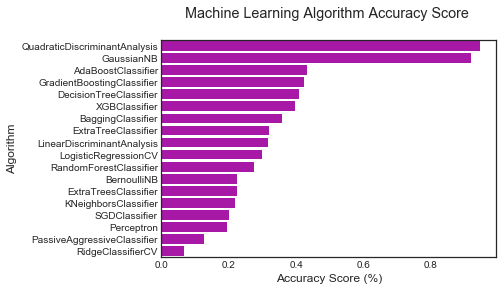

In [61]:
#barplot 
sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, color = 'm')

#prettify using pyplot
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

In [70]:
MLA_predict[MLA_predict['Drafted'] == 1]

,Drafted,AdaBoostClassifier,BaggingClassifier,ExtraTreesClassifier,GradientBoostingClassifier,RandomForestClassifier,LogisticRegressionCV,PassiveAggressiveClassifier,RidgeClassifierCV,SGDClassifier,Perceptron,BernoulliNB,GaussianNB,KNeighborsClassifier,DecisionTreeClassifier,ExtraTreeClassifier,LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis,XGBClassifier
Player ID,,,,,,,,,,,,,,,,,,,
/AJ-Hammons/Summary/24294,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
/AJ-Price/Summary/1656,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
/Aaron-Brooks/Summary/53,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
/Aaron-Gordon/Summary/24308,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
/Aaron-Gray/Summary/11,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
/Aaron-Harrison/Summary/24309,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
/Aaron-Miles/Summary/1106,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
/Acie-Law/Summary/38,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
/Adam-Morrison/Summary/67,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0


### Parameter Optimization and Feature Tuning
I'll take the best 5 models in recall, excluding the Quad. Discriminant Analysis and Gaussian Naive Bayes, whose results were unrealistic. I'll optimize them one at a time.

***Scoring: The goal of this first part of my overall model is to select players who are draft-worthy or NBA-worthy. It is difficult to accurately pick the small percentage of players (813/25,000 in our data) that will be play in the NBA, especially considering the inherint noise in data like this. Therefore, I have made a decision to focus on RECALL instead of ACCURACY as the scoring metric for our model evaluations. I want to error on the side of over-inclusion, preferring false-positives to false-negatives, as long as we are in a reasonable range of accuracy.

### AdaBoost

In [80]:
# Model selection process with cross validation.
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) 
# run model 10x with 60/30 split intentionally leaving out 10%

#base model
ada = ensemble.AdaBoostClassifier(n_estimators=80)
base_results = model_selection.cross_validate(ada, df[x], df[target], cv=cv_split, scoring='recall', n_jobs=-1)
ada.fit(df[x], df[target])

print('BEFORE DT Parameters: ', ada.get_params())
print("BEFORE DT Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE DT Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE DT Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
print("BEFORE DT Test w/bin set score min: {:.2f}". format(base_results['test_score'].min()*100))
print('-'*10)


#tune hyper-parameters: 
param_grid = {
#               'base_estimator': [tree.DecisionTreeClassifier(), ensemble.RandomForestClassifier(), tree.ExtraTreeClassifier(), ensemble.ExtraTreesClassifier()],
              'n_estimators': [80]
             }

#print(list(model_selection.ParameterGrid(param_grid)))

# choose best model with grid_search: 
tune_model = model_selection.GridSearchCV(ensemble.AdaBoostClassifier(), param_grid=param_grid, cv=cv_split, scoring='recall', n_jobs=-1)
tune_model.fit(df[x], df[target])

#print(tune_model.cv_results_.keys())
#print(tune_model.cv_results_['params'])
print('AFTER DT Parameters: ', tune_model.best_params_)
#print(tune_model.cv_results_['mean_train_score'])
print("AFTER DT Training w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100)) 
#print(tune_model.cv_results_['mean_test_score'])
print("AFTER DT Test w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print("AFTER DT Test w/bin score 3*std: +/- {:.2f}". format(tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100*3))
print('-'*10)


BEFORE DT Parameters:  {'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 1.0, 'n_estimators': 80, 'random_state': None}
BEFORE DT Training w/bin score mean: 50.16
BEFORE DT Test w/bin score mean: 44.08
BEFORE DT Test w/bin score 3*std: +/- 8.79
BEFORE DT Test w/bin set score min: 39.92
----------
AFTER DT Parameters:  {'n_estimators': 80}
AFTER DT Training w/bin score mean: 50.16
AFTER DT Test w/bin score mean: 44.08
AFTER DT Test w/bin score 3*std: +/- 8.79
----------


First pass AdaBoost Optimial Parameters before Feature Tuning: 
    base_estimator: default (DecisionTreeClassifier),
    n_estimators: 80

In [84]:
### Feature Tuning

#First-Pass model
print('BEFORE DT RFE Training Shape Old: ', df[x].shape) 
print('BEFORE DT RFE Training Columns Old: ', df[x].columns.values)

print("BEFORE DT RFE Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE DT RFE Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE DT RFE Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
print('-'*10)



#feature selection
ada_rfe = feature_selection.RFECV(ada, step = 1, scoring = 'recall', cv = cv_split, n_jobs=-1)
ada_rfe.fit(df[x], df[target])

#transform x&y to reduced features and fit new model
X_rfe = df[x].columns.values[ada_rfe.get_support()]
rfe_results = model_selection.cross_validate(ada, df[X_rfe], df[target], cv  = cv_split, scoring='recall', n_jobs=-1)

#print(dtree_rfe.grid_scores_)
print('AFTER DT RFE Training Shape New: ', df[X_rfe].shape) 
print('AFTER DT RFE Training Columns New: ', X_rfe)

print("AFTER DT RFE Training w/bin score mean: {:.2f}". format(rfe_results['train_score'].mean()*100)) 
print("AFTER DT RFE Test w/bin score mean: {:.2f}". format(rfe_results['test_score'].mean()*100))
print("AFTER DT RFE Test w/bin score 3*std: +/- {:.2f}". format(rfe_results['test_score'].std()*100*3))
print('-'*10)


#tune rfe model
rfe_tune_model = model_selection.GridSearchCV(ensemble.AdaBoostClassifier(), param_grid=param_grid, cv=cv_split, scoring='recall', n_jobs=-1)
rfe_tune_model.fit(df[X_rfe], df[target])

#print(rfe_tune_model.cv_results_.keys())
#print(rfe_tune_model.cv_results_['params'])
print('AFTER DT RFE Tuned Parameters: ', rfe_tune_model.best_params_)
#print(rfe_tune_model.cv_results_['mean_train_score'])
print("AFTER DT RFE Tuned Training w/bin score mean: {:.2f}". format(rfe_tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100)) 
#print(rfe_tune_model.cv_results_['mean_test_score'])
print("AFTER DT RFE Tuned Test w/bin score mean: {:.2f}". format(rfe_tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print("AFTER DT RFE Tuned Test w/bin score 3*std: +/- {:.2f}". format(rfe_tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100*3))
print('-'*10)

BEFORE DT RFE Training Shape Old:  (25975, 43)
BEFORE DT RFE Training Columns Old:  ['age_GP' 'age_GS' 'age_MIN' 'age_FG%' 'age_3P%' 'age_FT%' 'age_AST%'
 'age_BLK%' 'age_DRB%' 'age_DRtg' 'age_ORtg' 'age_PER' 'age_PPR' 'age_PPS'
 'age_STL%' 'age_TOV%' 'age_TRB%' 'age_TS%' 'age_Total S %' 'age_USG%'
 'age_eFG%' 'age_FGM_per100poss' 'age_FGA_per100poss' 'age_3PM_per100poss'
 'age_3PA_per100poss' 'age_FTM_per100poss' 'age_FTA_per100poss'
 'age_OFF_per100poss' 'age_DEF_per100poss' 'age_TRB_per100poss'
 'age_AST_per100poss' 'age_STL_per100poss' 'age_BLK_per100poss'
 'age_PF_per100poss' 'age_TOV_per100poss' 'age_PTS_per100poss' 'Height'
 'Age' 'inv_RSCI' 'Pos_B' 'Pos_G' 'Pos_PG' 'Pos_W']
BEFORE DT RFE Training w/bin score mean: 50.16
BEFORE DT RFE Test w/bin score mean: 44.08
BEFORE DT RFE Test w/bin score 3*std: +/- 8.79
----------
AFTER DT RFE Training Shape New:  (25975, 31)
AFTER DT RFE Training Columns New:  ['age_GP' 'age_GS' 'age_MIN' 'age_FG%' 'age_FT%' 'age_AST%' 'age_BLK%'
 'age_DR

AdaBoost:
1. Parameters: n_estimators: 80
2. Features: Total original x set had slightly higher test score, but the reduced 31 feature set was pretty close. Probably better to use smaller set. (Parsimony :) )

AFTER DT RFE Training Shape New:  (25975, 31)
AFTER DT RFE Training Columns New:  ['age_GP' 'age_GS' 'age_MIN' 'age_FG%' 'age_FT%' 'age_AST%' 'age_BLK%'
 'age_DRB%' 'age_DRtg' 'age_ORtg' 'age_PER' 'age_PPR' 'age_STL%' 'age_TOV%'
 'age_TRB%' 'age_Total S %' 'age_FGM_per100poss' 'age_FTM_per100poss'
 'age_OFF_per100poss' 'age_DEF_per100poss' 'age_TRB_per100poss'
 'age_AST_per100poss' 'age_BLK_per100poss' 'age_PF_per100poss'
 'age_TOV_per100poss' 'age_PTS_per100poss' 'Height' 'Age' 'inv_RSCI'
 'Pos_B' 'Pos_W']
AFTER DT RFE Training w/bin score mean: 50.25
AFTER DT RFE Test w/bin score mean: 43.39
AFTER DT RFE Test w/bin score 3*std: +/- 8.04

### GradientBoosting

In [94]:
# Model selection process with cross validation.
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) 
# run model 10x with 60/30 split intentionally leaving out 10%

#base model
grbst = ensemble.GradientBoostingClassifier(max_depth=3, min_samples_split=5, n_estimators=315)
base_results = model_selection.cross_validate(grbst, df[x], df[target], cv=cv_split, scoring='recall', n_jobs=-1)
grbst.fit(df[x], df[target])

print('BEFORE DT Parameters: ', grbst.get_params())
print("BEFORE DT Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE DT Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE DT Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
print("BEFORE DT Test w/bin set score min: {:.2f}". format(base_results['test_score'].min()*100))
print('-'*10)


#tune hyper-parameters: 
param_grid = {
#             'loss': ['deviance', 'exponential'],
              'n_estimators': [315],
               'max_depth': [3],
                'min_samples_split': [5],
#               'min_samples_leaf': [2, 3, 5]
             }

#print(list(model_selection.ParameterGrid(param_grid)))

# choose best model with grid_search: 
# tune_model = model_selection.GridSearchCV(ensemble.GradientBoostingClassifier(), param_grid=param_grid, cv=cv_split, scoring='recall', n_jobs=-1)
# tune_model.fit(df[x], df[target])

# #print(tune_model.cv_results_.keys())
# #print(tune_model.cv_results_['params'])
# print('AFTER DT Parameters: ', tune_model.best_params_)
# #print(tune_model.cv_results_['mean_train_score'])
# print("AFTER DT Training w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100)) 
# #print(tune_model.cv_results_['mean_test_score'])
# print("AFTER DT Test w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
# print("AFTER DT Test w/bin score 3*std: +/- {:.2f}". format(tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100*3))
# print('-'*10)

BEFORE DT Parameters:  {'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 315, 'presort': 'auto', 'random_state': None, 'subsample': 1.0, 'verbose': 0, 'warm_start': False}
BEFORE DT Training w/bin score mean: 81.30
BEFORE DT Test w/bin score mean: 43.78
BEFORE DT Test w/bin score 3*std: +/- 7.95
BEFORE DT Test w/bin set score min: 40.00
----------


First pass GradientBoost Optimial Parameters before Feature Tuning: 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 315

In [95]:
### Feature Tuning

#First-Pass model
print('BEFORE DT RFE Training Shape Old: ', df[x].shape) 
print('BEFORE DT RFE Training Columns Old: ', df[x].columns.values)

print("BEFORE DT RFE Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE DT RFE Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE DT RFE Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
print('-'*10)



#feature selection
grbst_rfe = feature_selection.RFECV(grbst, step = 1, scoring = 'recall', cv = cv_split, n_jobs=-1)
grbst_rfe.fit(df[x], df[target])

#transform x&y to reduced features and fit new model
X_rfe = df[x].columns.values[ada_rfe.get_support()]
rfe_results = model_selection.cross_validate(grbst, df[X_rfe], df[target], cv  = cv_split, scoring='recall', n_jobs=-1)

#print(dtree_rfe.grid_scores_)
print('AFTER DT RFE Training Shape New: ', df[X_rfe].shape) 
print('AFTER DT RFE Training Columns New: ', X_rfe)

print("AFTER DT RFE Training w/bin score mean: {:.2f}". format(rfe_results['train_score'].mean()*100)) 
print("AFTER DT RFE Test w/bin score mean: {:.2f}". format(rfe_results['test_score'].mean()*100))
print("AFTER DT RFE Test w/bin score 3*std: +/- {:.2f}". format(rfe_results['test_score'].std()*100*3))
print('-'*10)


#tune rfe model
rfe_tune_model = model_selection.GridSearchCV(ensemble.GradientBoostingClassifier(), param_grid=param_grid, cv=cv_split, scoring='recall', n_jobs=-1)
rfe_tune_model.fit(df[X_rfe], df[target])

#print(rfe_tune_model.cv_results_.keys())
#print(rfe_tune_model.cv_results_['params'])
print('AFTER DT RFE Tuned Parameters: ', rfe_tune_model.best_params_)
#print(rfe_tune_model.cv_results_['mean_train_score'])
print("AFTER DT RFE Tuned Training w/bin score mean: {:.2f}". format(rfe_tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100)) 
#print(rfe_tune_model.cv_results_['mean_test_score'])
print("AFTER DT RFE Tuned Test w/bin score mean: {:.2f}". format(rfe_tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print("AFTER DT RFE Tuned Test w/bin score 3*std: +/- {:.2f}". format(rfe_tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100*3))
print('-'*10)

BEFORE DT RFE Training Shape Old:  (25975, 43)
BEFORE DT RFE Training Columns Old:  ['age_GP' 'age_GS' 'age_MIN' 'age_FG%' 'age_3P%' 'age_FT%' 'age_AST%'
 'age_BLK%' 'age_DRB%' 'age_DRtg' 'age_ORtg' 'age_PER' 'age_PPR' 'age_PPS'
 'age_STL%' 'age_TOV%' 'age_TRB%' 'age_TS%' 'age_Total S %' 'age_USG%'
 'age_eFG%' 'age_FGM_per100poss' 'age_FGA_per100poss' 'age_3PM_per100poss'
 'age_3PA_per100poss' 'age_FTM_per100poss' 'age_FTA_per100poss'
 'age_OFF_per100poss' 'age_DEF_per100poss' 'age_TRB_per100poss'
 'age_AST_per100poss' 'age_STL_per100poss' 'age_BLK_per100poss'
 'age_PF_per100poss' 'age_TOV_per100poss' 'age_PTS_per100poss' 'Height'
 'Age' 'inv_RSCI' 'Pos_B' 'Pos_G' 'Pos_PG' 'Pos_W']
BEFORE DT RFE Training w/bin score mean: 81.30
BEFORE DT RFE Test w/bin score mean: 43.78
BEFORE DT RFE Test w/bin score 3*std: +/- 7.95
----------
AFTER DT RFE Training Shape New:  (25975, 31)
AFTER DT RFE Training Columns New:  ['age_GP' 'age_GS' 'age_MIN' 'age_FG%' 'age_FT%' 'age_AST%' 'age_BLK%'
 'age_DR

AttributeError: module 'sklearn.ensemble' has no attribute 'GradientBoostClassifier'

AFTER DT RFE Training Shape New:  (25975, 31)
AFTER DT RFE Training Columns New:  ['age_GP' 'age_GS' 'age_MIN' 'age_FG%' 'age_FT%' 'age_AST%' 'age_BLK%'
 'age_DRB%' 'age_DRtg' 'age_ORtg' 'age_PER' 'age_PPR' 'age_STL%' 'age_TOV%'
 'age_TRB%' 'age_Total S %' 'age_FGM_per100poss' 'age_FTM_per100poss'
 'age_OFF_per100poss' 'age_DEF_per100poss' 'age_TRB_per100poss'
 'age_AST_per100poss' 'age_BLK_per100poss' 'age_PF_per100poss'
 'age_TOV_per100poss' 'age_PTS_per100poss' 'Height' 'Age' 'inv_RSCI'
 'Pos_B' 'Pos_W']
AFTER DT RFE Training w/bin score mean: 80.46
AFTER DT RFE Test w/bin score mean: 43.27
AFTER DT RFE Test w/bin score 3*std: +/- 9.18

### Decision Tree 

In [103]:
# Model selection process with cross validation.
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) 
# run model 10x with 60/30 split intentionally leaving out 10%

#base model
dtree = tree.DecisionTreeClassifier()
base_results = model_selection.cross_validate(dtree, df[x], df[target], cv=cv_split, scoring='recall', n_jobs=-1)
dtree.fit(df[x], df[target])

print('BEFORE DT Parameters: ', dtree.get_params())
print("BEFORE DT Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE DT Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE DT Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
print("BEFORE DT Test w/bin set score min: {:.2f}". format(base_results['test_score'].min()*100))
print('-'*10)


#tune hyper-parameters: 
param_grid = {
                'max_depth': [None],
                 'min_samples_split': [2],
              'min_samples_leaf': [1]
             }

#print(list(model_selection.ParameterGrid(param_grid)))

# choose best model with grid_search: 
tune_model = model_selection.GridSearchCV(tree.DecisionTreeClassifier(), param_grid=param_grid, cv=cv_split, scoring='recall', n_jobs=-1)
tune_model.fit(df[x], df[target])

#print(tune_model.cv_results_.keys())
#print(tune_model.cv_results_['params'])
print('AFTER DT Parameters: ', tune_model.best_params_)
#print(tune_model.cv_results_['mean_train_score'])
print("AFTER DT Training w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100)) 
#print(tune_model.cv_results_['mean_test_score'])
print("AFTER DT Test w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print("AFTER DT Test w/bin score 3*std: +/- {:.2f}". format(tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100*3))
print('-'*10)

BEFORE DT Parameters:  {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': None, 'splitter': 'best'}
BEFORE DT Training w/bin score mean: 100.00
BEFORE DT Test w/bin score mean: 41.20
BEFORE DT Test w/bin score 3*std: +/- 7.04
BEFORE DT Test w/bin set score min: 37.14
----------
AFTER DT Parameters:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
AFTER DT Training w/bin score mean: 100.00
AFTER DT Test w/bin score mean: 41.17
AFTER DT Test w/bin score 3*std: +/- 10.29
----------


AFTER DT Parameters:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
AFTER DT Training w/bin score mean: 100.00
AFTER DT Test w/bin score mean: 41.17
AFTER DT Test w/bin score 3*std: +/- 10.29

In [104]:
### Feature Tuning

#First-Pass model
print('BEFORE DT RFE Training Shape Old: ', df[x].shape) 
print('BEFORE DT RFE Training Columns Old: ', df[x].columns.values)

print("BEFORE DT RFE Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE DT RFE Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE DT RFE Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
print('-'*10)



#feature selection
dtree_rfe = feature_selection.RFECV(dtree, step = 1, scoring = 'recall', cv = cv_split, n_jobs=-1)
dtree_rfe.fit(df[x], df[target])

#transform x&y to reduced features and fit new model
X_rfe = df[x].columns.values[dtree_rfe.get_support()]
rfe_results = model_selection.cross_validate(dtree, df[X_rfe], df[target], cv  = cv_split, scoring='recall', n_jobs=-1)

#print(dtree_rfe.grid_scores_)
print('AFTER DT RFE Training Shape New: ', df[X_rfe].shape) 
print('AFTER DT RFE Training Columns New: ', X_rfe)

print("AFTER DT RFE Training w/bin score mean: {:.2f}". format(rfe_results['train_score'].mean()*100)) 
print("AFTER DT RFE Test w/bin score mean: {:.2f}". format(rfe_results['test_score'].mean()*100))
print("AFTER DT RFE Test w/bin score 3*std: +/- {:.2f}". format(rfe_results['test_score'].std()*100*3))
print('-'*10)


#tune rfe model
rfe_tune_model = model_selection.GridSearchCV(tree.DecisionTreeClassifier(), param_grid=param_grid, cv=cv_split, scoring='recall', n_jobs=-1)
rfe_tune_model.fit(df[X_rfe], df[target])

#print(rfe_tune_model.cv_results_.keys())
#print(rfe_tune_model.cv_results_['params'])
print('AFTER DT RFE Tuned Parameters: ', rfe_tune_model.best_params_)
#print(rfe_tune_model.cv_results_['mean_train_score'])
print("AFTER DT RFE Tuned Training w/bin score mean: {:.2f}". format(rfe_tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100)) 
#print(rfe_tune_model.cv_results_['mean_test_score'])
print("AFTER DT RFE Tuned Test w/bin score mean: {:.2f}". format(rfe_tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print("AFTER DT RFE Tuned Test w/bin score 3*std: +/- {:.2f}". format(rfe_tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100*3))
print('-'*10)

BEFORE DT RFE Training Shape Old:  (25975, 43)
BEFORE DT RFE Training Columns Old:  ['age_GP' 'age_GS' 'age_MIN' 'age_FG%' 'age_3P%' 'age_FT%' 'age_AST%'
 'age_BLK%' 'age_DRB%' 'age_DRtg' 'age_ORtg' 'age_PER' 'age_PPR' 'age_PPS'
 'age_STL%' 'age_TOV%' 'age_TRB%' 'age_TS%' 'age_Total S %' 'age_USG%'
 'age_eFG%' 'age_FGM_per100poss' 'age_FGA_per100poss' 'age_3PM_per100poss'
 'age_3PA_per100poss' 'age_FTM_per100poss' 'age_FTA_per100poss'
 'age_OFF_per100poss' 'age_DEF_per100poss' 'age_TRB_per100poss'
 'age_AST_per100poss' 'age_STL_per100poss' 'age_BLK_per100poss'
 'age_PF_per100poss' 'age_TOV_per100poss' 'age_PTS_per100poss' 'Height'
 'Age' 'inv_RSCI' 'Pos_B' 'Pos_G' 'Pos_PG' 'Pos_W']
BEFORE DT RFE Training w/bin score mean: 100.00
BEFORE DT RFE Test w/bin score mean: 41.20
BEFORE DT RFE Test w/bin score 3*std: +/- 7.04
----------
AFTER DT RFE Training Shape New:  (25975, 12)
AFTER DT RFE Training Columns New:  ['age_GP' 'age_MIN' 'age_DRtg' 'age_PER' 'age_STL%' 'age_FGM_per100poss'
 'age

AFTER DT RFE Training Shape New:  (25975, 12)
AFTER DT RFE Training Columns New:  ['age_GP' 'age_MIN' 'age_DRtg' 'age_PER' 'age_STL%' 'age_FGM_per100poss'
 'age_3PA_per100poss' 'age_FTA_per100poss' 'age_BLK_per100poss'
 'age_TOV_per100poss' 'Age' 'inv_RSCI']
AFTER DT RFE Training w/bin score mean: 100.00
AFTER DT RFE Test w/bin score mean: 40.42
AFTER DT RFE Test w/bin score 3*std: +/- 7.46

AFTER DT RFE Tuned Parameters:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
AFTER DT RFE Tuned Training w/bin score mean: 100.00
AFTER DT RFE Tuned Test w/bin score mean: 40.10
AFTER DT RFE Tuned Test w/bin score 3*std: +/- 9.39

### XGBoost

In [108]:
# Model selection process with cross validation.
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) 
# run model 10x with 60/30 split intentionally leaving out 10%

#base model
xgb = XGBClassifier()
base_results = model_selection.cross_validate(XGBClassifier(), df[x], df[target], cv=cv_split, scoring='recall', n_jobs=-1)
xgb.fit(df[x], df[target])


print('BEFORE DT Parameters: ', xgb.get_params())
print("BEFORE DT Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE DT Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE DT Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
print("BEFORE DT Test w/bin set score min: {:.2f}". format(base_results['test_score'].min()*100))
print('-'*10)


#tune hyper-parameters: 
param_grid = {
                'max_depth': [3],
                'n_estimators': [250]
             }

#print(list(model_selection.ParameterGrid(param_grid)))

# choose best model with grid_search: 
tune_model = model_selection.GridSearchCV(XGBClassifier(), param_grid=param_grid, cv=cv_split, scoring='recall', n_jobs=-1)
tune_model.fit(df[x], df[target])

#print(tune_model.cv_results_.keys())
#print(tune_model.cv_results_['params'])
print('AFTER DT Parameters: ', tune_model.best_params_)
#print(tune_model.cv_results_['mean_train_score'])
print("AFTER DT Training w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100)) 
#print(tune_model.cv_results_['mean_test_score'])
print("AFTER DT Test w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print("AFTER DT Test w/bin score 3*std: +/- {:.2f}". format(tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100*3))
print('-'*10)

BEFORE DT Parameters:  {'base_score': 0.5, 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'nthread': -1, 'objective': 'binary:logistic', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'silent': True, 'subsample': 1}
BEFORE DT Training w/bin score mean: 51.48
BEFORE DT Test w/bin score mean: 39.67
BEFORE DT Test w/bin score 3*std: +/- 8.15
BEFORE DT Test w/bin set score min: 35.92
----------
AFTER DT Parameters:  {'max_depth': 3, 'n_estimators': 250}
AFTER DT Training w/bin score mean: 69.81
AFTER DT Test w/bin score mean: 42.62
AFTER DT Test w/bin score 3*std: +/- 6.38
----------


AFTER DT Parameters:  {'max_depth': 3, 'n_estimators': 250}
AFTER DT Training w/bin score mean: 69.81
AFTER DT Test w/bin score mean: 42.62
AFTER DT Test w/bin score 3*std: +/- 6.38

In [109]:
### Feature Tuning

#First-Pass model
print('BEFORE DT RFE Training Shape Old: ', df[x].shape) 
print('BEFORE DT RFE Training Columns Old: ', df[x].columns.values)

print("BEFORE DT RFE Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE DT RFE Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE DT RFE Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
print('-'*10)



#feature selection
xgb_rfe = feature_selection.RFECV(xgb, step = 1, scoring = 'recall', cv = cv_split, n_jobs=-1)
xgb_rfe.fit(df[x], df[target])

#transform x&y to reduced features and fit new model
X_rfe = df[x].columns.values[xgb_rfe.get_support()]
rfe_results = model_selection.cross_validate(xgb, df[X_rfe], df[target], cv  = cv_split, scoring='recall', n_jobs=-1)

#print(dtree_rfe.grid_scores_)
print('AFTER DT RFE Training Shape New: ', df[X_rfe].shape) 
print('AFTER DT RFE Training Columns New: ', X_rfe)

print("AFTER DT RFE Training w/bin score mean: {:.2f}". format(rfe_results['train_score'].mean()*100)) 
print("AFTER DT RFE Test w/bin score mean: {:.2f}". format(rfe_results['test_score'].mean()*100))
print("AFTER DT RFE Test w/bin score 3*std: +/- {:.2f}". format(rfe_results['test_score'].std()*100*3))
print('-'*10)


#tune rfe model
rfe_tune_model = model_selection.GridSearchCV(XGBClassifier(), param_grid=param_grid, cv=cv_split, scoring='recall', n_jobs=-1)
rfe_tune_model.fit(df[X_rfe], df[target])

#print(rfe_tune_model.cv_results_.keys())
#print(rfe_tune_model.cv_results_['params'])
print('AFTER DT RFE Tuned Parameters: ', rfe_tune_model.best_params_)
#print(rfe_tune_model.cv_results_['mean_train_score'])
print("AFTER DT RFE Tuned Training w/bin score mean: {:.2f}". format(rfe_tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100)) 
#print(rfe_tune_model.cv_results_['mean_test_score'])
print("AFTER DT RFE Tuned Test w/bin score mean: {:.2f}". format(rfe_tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print("AFTER DT RFE Tuned Test w/bin score 3*std: +/- {:.2f}". format(rfe_tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100*3))
print('-'*10)

BEFORE DT RFE Training Shape Old:  (25975, 43)
BEFORE DT RFE Training Columns Old:  ['age_GP' 'age_GS' 'age_MIN' 'age_FG%' 'age_3P%' 'age_FT%' 'age_AST%'
 'age_BLK%' 'age_DRB%' 'age_DRtg' 'age_ORtg' 'age_PER' 'age_PPR' 'age_PPS'
 'age_STL%' 'age_TOV%' 'age_TRB%' 'age_TS%' 'age_Total S %' 'age_USG%'
 'age_eFG%' 'age_FGM_per100poss' 'age_FGA_per100poss' 'age_3PM_per100poss'
 'age_3PA_per100poss' 'age_FTM_per100poss' 'age_FTA_per100poss'
 'age_OFF_per100poss' 'age_DEF_per100poss' 'age_TRB_per100poss'
 'age_AST_per100poss' 'age_STL_per100poss' 'age_BLK_per100poss'
 'age_PF_per100poss' 'age_TOV_per100poss' 'age_PTS_per100poss' 'Height'
 'Age' 'inv_RSCI' 'Pos_B' 'Pos_G' 'Pos_PG' 'Pos_W']
BEFORE DT RFE Training w/bin score mean: 51.48
BEFORE DT RFE Test w/bin score mean: 39.67
BEFORE DT RFE Test w/bin score 3*std: +/- 8.15
----------
AFTER DT RFE Training Shape New:  (25975, 14)
AFTER DT RFE Training Columns New:  ['age_GP' 'age_GS' 'age_MIN' 'age_AST%' 'age_DRB%' 'age_DRtg' 'age_PER'
 'age_F

AFTER DT RFE Training Shape New:  (25975, 14)
AFTER DT RFE Training Columns New:  ['age_GP' 'age_GS' 'age_MIN' 'age_AST%' 'age_DRB%' 'age_DRtg' 'age_PER'
 'age_FTM_per100poss' 'age_OFF_per100poss' 'age_AST_per100poss'
 'age_PTS_per100poss' 'Height' 'Age' 'inv_RSCI']
AFTER DT RFE Training w/bin score mean: 49.52
AFTER DT RFE Test w/bin score mean: 39.93
AFTER DT RFE Test w/bin score 3*std: +/- 8.27

AFTER DT RFE Tuned Parameters:  {'max_depth': 3, 'n_estimators': 250}
AFTER DT RFE Tuned Training w/bin score mean: 63.39
AFTER DT RFE Tuned Test w/bin score mean: 42.21
AFTER DT RFE Tuned Test w/bin score 3*std: +/- 6.29

### Bagging

In [44]:
# # Model selection process with cross validation.
# cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) 
# # run model 10x with 60/30 split intentionally leaving out 10%

#base model
bag = ensemble.BaggingClassifier()
base_results = model_selection.cross_validate(bag, df[x], df[target], cv=cv_split, scoring='recall', n_jobs=-1)
bag.fit(df[x], df[target])


print('BEFORE DT Parameters: ', bag.get_params())
print("BEFORE DT Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE DT Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE DT Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
print("BEFORE DT Test w/bin set score min: {:.2f}". format(base_results['test_score'].min()*100))
print('-'*10)


#tune hyper-parameters: 
param_grid = {
                'base_estimator': [ensemble.GradientBoostingClassifier()],
                'n_estimators': [25],
                'bootstrap_features': [False]
             }

#print(list(model_selection.ParameterGrid(param_grid)))

# choose best model with grid_search: 
tune_model = model_selection.GridSearchCV(ensemble.BaggingClassifier(), param_grid=param_grid, cv=cv_split, scoring='recall', n_jobs=-1)
tune_model.fit(df[x], df[target])

#print(tune_model.cv_results_.keys())
#print(tune_model.cv_results_['params'])
print('AFTER DT Parameters: ', tune_model.best_params_)
#print(tune_model.cv_results_['mean_train_score'])
print("AFTER DT Training w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100)) 
#print(tune_model.cv_results_['mean_test_score'])
print("AFTER DT Test w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print("AFTER DT Test w/bin score 3*std: +/- {:.2f}". format(tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100*3))
print('-'*10)

AFTER DT Parameters:  {'base_estimator': GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False), 'bootstrap_features': False, 'n_estimators': 25}
AFTER DT Training w/bin score mean: 54.05
AFTER DT Test w/bin score mean: 42.39
AFTER DT Test w/bin score 3*std: +/- 7.14
----------


AFTER DT Parameters:  {'base_estimator': GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False), 'bootstrap_features': False, 'n_estimators': 25}
AFTER DT Training w/bin score mean: 54.05
AFTER DT Test w/bin score mean: 42.39
AFTER DT Test w/bin score 3*std: +/- 7.14

In [50]:
#base model
bag = ensemble.BaggingClassifier(base_estimator=ensemble.GradientBoostingClassifier(), n_estimators=25)
base_results = model_selection.cross_validate(bag, df[x], df[target], cv=cv_split, scoring='recall', n_jobs=-1)
bag.fit(df[x], df[target])


print('BEFORE DT Parameters: ', bag.get_params())
print("BEFORE DT Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE DT Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE DT Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
print("BEFORE DT Test w/bin set score min: {:.2f}". format(base_results['test_score'].min()*100))
print('-'*10)

param_grid = {
                'base_estimator': [ensemble.GradientBoostingClassifier()],
                'n_estimators': [25],
                'bootstrap_features': [False]
             }

### Feature Tuning

#First-Pass model
print('BEFORE DT RFE Training Shape Old: ', df[x].shape) 
print('BEFORE DT RFE Training Columns Old: ', df[x].columns.values)

print("BEFORE DT RFE Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE DT RFE Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE DT RFE Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
print('-'*10)



#feature selection
bag_rfe = feature_selection.RFECV(bag, step = 1, scoring = 'recall', cv = cv_split, n_jobs=-1)
bag_rfe.fit(df[x], df[target])

#transform x&y to reduced features and fit new model
X_rfe = df[x].columns.values[bag_rfe.get_support()]
rfe_results = model_selection.cross_validate(bag, df[X_rfe], df[target], cv  = cv_split, scoring='recall', n_jobs=-1)

#print(dtree_rfe.grid_scores_)
print('AFTER DT RFE Training Shape New: ', df[X_rfe].shape) 
print('AFTER DT RFE Training Columns New: ', X_rfe)

print("AFTER DT RFE Training w/bin score mean: {:.2f}". format(rfe_results['train_score'].mean()*100)) 
print("AFTER DT RFE Test w/bin score mean: {:.2f}". format(rfe_results['test_score'].mean()*100))
print("AFTER DT RFE Test w/bin score 3*std: +/- {:.2f}". format(rfe_results['test_score'].std()*100*3))
print('-'*10)


#tune rfe model
rfe_tune_model = model_selection.GridSearchCV(ensemble.BaggingClassifier(), param_grid=param_grid, cv=cv_split, scoring='recall', n_jobs=-1)
rfe_tune_model.fit(df[X_rfe], df[target])

#print(rfe_tune_model.cv_results_.keys())
#print(rfe_tune_model.cv_results_['params'])
print('AFTER DT RFE Tuned Parameters: ', rfe_tune_model.best_params_)
#print(rfe_tune_model.cv_results_['mean_train_score'])
print("AFTER DT RFE Tuned Training w/bin score mean: {:.2f}". format(rfe_tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100)) 
#print(rfe_tune_model.cv_results_['mean_test_score'])
print("AFTER DT RFE Tuned Test w/bin score mean: {:.2f}". format(rfe_tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print("AFTER DT RFE Tuned Test w/bin score 3*std: +/- {:.2f}". format(rfe_tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100*3))
print('-'*10)

BEFORE DT Parameters:  {'base_estimator__criterion': 'friedman_mse', 'base_estimator__init': None, 'base_estimator__learning_rate': 0.1, 'base_estimator__loss': 'deviance', 'base_estimator__max_depth': 3, 'base_estimator__max_features': None, 'base_estimator__max_leaf_nodes': None, 'base_estimator__min_impurity_decrease': 0.0, 'base_estimator__min_impurity_split': None, 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 2, 'base_estimator__min_weight_fraction_leaf': 0.0, 'base_estimator__n_estimators': 100, 'base_estimator__presort': 'auto', 'base_estimator__random_state': None, 'base_estimator__subsample': 1.0, 'base_estimator__verbose': 0, 'base_estimator__warm_start': False, 'base_estimator': GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_sampl

JoblibRuntimeError: JoblibRuntimeError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
C:\Users\Sean\Anaconda3\envs\Sean\lib\runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...Sean\\lib\\site-packages\\ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
C:\Users\Sean\Anaconda3\envs\Sean\lib\runpy.py in _run_code(code=<code object <module> at 0x000001DEDBA9AE40, fil...lib\site-packages\ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\Users\Sean\Anaconda3\envs\Sean\lib\site-packages\__pycache__\ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\Users\Sean\Anaconda3\envs\Sean\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...Sean\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\Users\\S...an\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...Sean\\lib\\site-packages\\ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x000001DEDBA9AE40, fil...lib\site-packages\ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\Users\Sean\Anaconda3\envs\Sean\lib\site-packages\__pycache__\ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\Users\Sean\Anaconda3\envs\Sean\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...Sean\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\Users\\S...an\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
C:\Users\Sean\Anaconda3\envs\Sean\lib\site-packages\ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
C:\Users\Sean\Anaconda3\envs\Sean\lib\site-packages\traitlets\config\application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
C:\Users\Sean\Anaconda3\envs\Sean\lib\site-packages\ipykernel\kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         self.io_loop = ioloop.IOLoop.current()
    477         try:
--> 478             self.io_loop.start()
        self.io_loop.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    479         except KeyboardInterrupt:
    480             pass
    481 
    482 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
C:\Users\Sean\Anaconda3\envs\Sean\lib\site-packages\zmq\eventloop\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
C:\Users\Sean\Anaconda3\envs\Sean\lib\site-packages\tornado\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
C:\Users\Sean\Anaconda3\envs\Sean\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
C:\Users\Sean\Anaconda3\envs\Sean\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
C:\Users\Sean\Anaconda3\envs\Sean\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
C:\Users\Sean\Anaconda3\envs\Sean\lib\site-packages\zmq\eventloop\zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
C:\Users\Sean\Anaconda3\envs\Sean\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
C:\Users\Sean\Anaconda3\envs\Sean\lib\site-packages\ipykernel\kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    276         if self.control_stream:
    277             self.control_stream.on_recv(self.dispatch_control, copy=False)
    278 
    279         def make_dispatcher(stream):
    280             def dispatcher(msg):
--> 281                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    282             return dispatcher
    283 
    284         for s in self.shell_streams:
    285             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
C:\Users\Sean\Anaconda3\envs\Sean\lib\site-packages\ipykernel\kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': "#base model\nbag = ensemble.BaggingClassifier(bas...e'][tune_model.best_index_]*100*3))\nprint('-'*10)", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 2, 2, 0, 7, 14, 27692, tzinfo=tzutc()), 'msg_id': '5A9C7E923C084574A0AD1E028803708D', 'msg_type': 'execute_request', 'session': '93F233AA5CC442B88F19C9B7EE87B0E3', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '5A9C7E923C084574A0AD1E028803708D', 'msg_type': 'execute_request', 'parent_header': {}})
    227             self.log.warn("Unknown message type: %r", msg_type)
    228         else:
    229             self.log.debug("%s: %s", msg_type, msg)
    230             self.pre_handler_hook()
    231             try:
--> 232                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'93F233AA5CC442B88F19C9B7EE87B0E3']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': "#base model\nbag = ensemble.BaggingClassifier(bas...e'][tune_model.best_index_]*100*3))\nprint('-'*10)", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 2, 2, 0, 7, 14, 27692, tzinfo=tzutc()), 'msg_id': '5A9C7E923C084574A0AD1E028803708D', 'msg_type': 'execute_request', 'session': '93F233AA5CC442B88F19C9B7EE87B0E3', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '5A9C7E923C084574A0AD1E028803708D', 'msg_type': 'execute_request', 'parent_header': {}}
    233             except Exception:
    234                 self.log.error("Exception in message handler:", exc_info=True)
    235             finally:
    236                 self.post_handler_hook()

...........................................................................
C:\Users\Sean\Anaconda3\envs\Sean\lib\site-packages\ipykernel\kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'93F233AA5CC442B88F19C9B7EE87B0E3'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': "#base model\nbag = ensemble.BaggingClassifier(bas...e'][tune_model.best_index_]*100*3))\nprint('-'*10)", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 2, 2, 0, 7, 14, 27692, tzinfo=tzutc()), 'msg_id': '5A9C7E923C084574A0AD1E028803708D', 'msg_type': 'execute_request', 'session': '93F233AA5CC442B88F19C9B7EE87B0E3', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '5A9C7E923C084574A0AD1E028803708D', 'msg_type': 'execute_request', 'parent_header': {}})
    392         if not silent:
    393             self.execution_count += 1
    394             self._publish_execute_input(code, parent, self.execution_count)
    395 
    396         reply_content = self.do_execute(code, silent, store_history,
--> 397                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    398 
    399         # Flush output before sending the reply.
    400         sys.stdout.flush()
    401         sys.stderr.flush()

...........................................................................
C:\Users\Sean\Anaconda3\envs\Sean\lib\site-packages\ipykernel\ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code="#base model\nbag = ensemble.BaggingClassifier(bas...e'][tune_model.best_index_]*100*3))\nprint('-'*10)", silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = "#base model\nbag = ensemble.BaggingClassifier(bas...e'][tune_model.best_index_]*100*3))\nprint('-'*10)"
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
C:\Users\Sean\Anaconda3\envs\Sean\lib\site-packages\ipykernel\zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=("#base model\nbag = ensemble.BaggingClassifier(bas...e'][tune_model.best_index_]*100*3))\nprint('-'*10)",), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ("#base model\nbag = ensemble.BaggingClassifier(bas...e'][tune_model.best_index_]*100*3))\nprint('-'*10)",)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
C:\Users\Sean\Anaconda3\envs\Sean\lib\site-packages\IPython\core\interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell="#base model\nbag = ensemble.BaggingClassifier(bas...e'][tune_model.best_index_]*100*3))\nprint('-'*10)", store_history=True, silent=False, shell_futures=True)
   2723                 self.displayhook.exec_result = result
   2724 
   2725                 # Execute the user code
   2726                 interactivity = "none" if silent else self.ast_node_interactivity
   2727                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2728                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2729                 
   2730                 self.last_execution_succeeded = not has_raised
   2731                 self.last_execution_result = result
   2732 

...........................................................................
C:\Users\Sean\Anaconda3\envs\Sean\lib\site-packages\IPython\core\interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Assign object>, <_ast.Expr object>, <_ast.Expr object>, <_ast.Expr object>, <_ast.Expr object>, <_ast.Expr object>, <_ast.Expr object>, <_ast.Expr object>, <_ast.Assign object>, <_ast.Expr object>, <_ast.Expr object>, <_ast.Expr object>, <_ast.Expr object>, <_ast.Expr object>, <_ast.Expr object>, <_ast.Assign object>, <_ast.Expr object>, <_ast.Assign object>, <_ast.Assign object>, ...], cell_name='<ipython-input-50-96215ee96f91>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 1deedee0a90, executio..._before_exec=None error_in_exec=None result=None>)
   2845 
   2846         try:
   2847             for i, node in enumerate(to_run_exec):
   2848                 mod = ast.Module([node])
   2849                 code = compiler(mod, cell_name, "exec")
-> 2850                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x000001DEEDF87E40, file "<ipython-input-50-96215ee96f91>", line 35>
        result = <ExecutionResult object at 1deedee0a90, executio..._before_exec=None error_in_exec=None result=None>
   2851                     return True
   2852 
   2853             for i, node in enumerate(to_run_interactive):
   2854                 mod = ast.Interactive([node])

...........................................................................
C:\Users\Sean\Anaconda3\envs\Sean\lib\site-packages\IPython\core\interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x000001DEEDF87E40, file "<ipython-input-50-96215ee96f91>", line 35>, result=<ExecutionResult object at 1deedee0a90, executio..._before_exec=None error_in_exec=None result=None>)
   2905         outflag = True  # happens in more places, so it's easier as default
   2906         try:
   2907             try:
   2908                 self.hooks.pre_run_code_hook()
   2909                 #rprint('Running code', repr(code_obj)) # dbg
-> 2910                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x000001DEEDF87E40, file "<ipython-input-50-96215ee96f91>", line 35>
        self.user_global_ns = {'IPython': <module 'IPython' from 'C:\\Users\\Sean\\Anacond...\Sean\\lib\\site-packages\\IPython\\__init__.py'>, 'In': ['', "#load packages\nimport sys #access to system para...s\nwarnings.filterwarnings('ignore')\nprint('-'*25)", "#Common Model Algorithms\nfrom sklearn import svm...('white')\npylab.rcParams['figure.figsize'] = 12,8", "# Make all columns in dataframe output visible\np...f].info())\n    print('\\n')\n    print('-'*30)\n    ", "# Merge totals and advanced\ncols_to_merge = adva...rge(pace, how='left', on=['Team Name', 'Season'])", "### Add Target variable from drafted_signed data...ed' with 0.\ndf['Drafted'].fillna(0, inplace=True)", "# drop unwanted columns \ncol_drop = ['2Y Season'... School']\ndf.drop(col_drop, axis=1, inplace=True)", 'df.columns', "### What to do with Class?\ndf['Class'] = df['Cla...ttribute distribution:\ndf['Class'].value_counts()", "# Remove 'Trans' and all '(Ineligible)' values.\n...e)']\ndf = df[-df['Class'].isin(rmv_class_values)]", "# Convert numeric columns to a numeric data type...umn] = pd.to_numeric(df[column], errors='coerce')", "# Current values of 'Position' attribute.\ndf['Position'].unique()", "# Map old positions to new positions and create ...t a position.\ndf = df[pd.notnull(df['Position'])]", 'df.info()', "# Make temporary dataframe with height and posit...])\nht_pos_df.drop('Height', axis=1, inplace=True)", "# Find average height by position.\npos_ht_mean = ht_pos_df.groupby('Position').mean()\npos_ht_mean", "# Replace '-' in Height column of df.\ndf['Height..._numeric(\n    df['Height'].str.split('-').str[1])", "# Make dictionary of height averages by position... type.\ndf['Height'] = pd.to_numeric(df['Height'])", "# Get rid of '-' in column.\ndf['Birthday Code']....num', 'Player Season Num'], axis=1, inplace=True)", "# List of player ids who are too young and too o...me.\ndf = df[~df['Player ID'].isin(rmv_playerids)]", ...], 'LabelEncoder': <class 'sklearn.preprocessing.label.LabelEncoder'>, 'MLA': [AdaBoostClassifier(algorithm='SAMME.R', base_est...ing_rate=1.0, n_estimators=50, random_state=None), BaggingClassifier(base_estimator=None, bootstrap...state=None,
         verbose=0, warm_start=False), ExtraTreesClassifier(bootstrap=False, class_weig..., random_state=None, verbose=0, warm_start=False), GradientBoostingClassifier(criterion='friedman_m...e=1.0, verbose=0,
              warm_start=False), RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), LogisticRegressionCV(Cs=10, class_weight=None, c...ring=None, solver='lbfgs', tol=0.0001, verbose=0), PassiveAggressiveClassifier(C=1.0, average=False...=None,
              verbose=0, warm_start=False), RidgeClassifierCV(alphas=(0.1, 1.0, 10.0), class...it_intercept=True, normalize=False, scoring=None), SGDClassifier(alpha=0.0001, average=False, class...ffle=True, tol=None, verbose=0, warm_start=False), Perceptron(alpha=0.0001, class_weight=None, eta0...ffle=True, tol=None, verbose=0, warm_start=False), BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True), GaussianNB(priors=None), KNeighborsClassifier(algorithm='auto', leaf_size...n_neighbors=5, p=2,
           weights='uniform'), DecisionTreeClassifier(class_weight=None, criter..., random_state=None,
            splitter='best'), ExtraTreeClassifier(class_weight=None, criterion..., random_state=None,
          splitter='random'), LinearDiscriminantAnalysis(n_components=None, pr...solver='svd', store_covariance=False, tol=0.0001), QuadraticDiscriminantAnalysis(priors=None, reg_p...riance=False, store_covariances=None, tol=0.0001), XGBClassifier(base_score=0.5, colsample_bylevel=...e_pos_weight=1, seed=0, silent=True, subsample=1)], 'OneHotEncoder': <class 'sklearn.preprocessing.data.OneHotEncoder'>, 'Out': {7: Index(['Player Name', 'Player ID', 'Player Seaso...
       'Pace', 'Drafted'],
      dtype='object'), 8: Fr                 30180
So                 2582...o (Ineligible)        2
Name: Class, dtype: int64, 11: array(['G', 'C', 'PG', 'GF', 'SG', 'F', 'F-G', n... 'SF',
       'F-C', 'G-F', 'C-F'], dtype=object), 15:           height_inches
Position               
...9
PG            72.186659
W             77.687597, 22: (64210, 48), 23: (64210, 48), 24: (64210, 47), 25: (64108, 47), 26: (64108, 47), 28: Index(['Player Name', 'Player ID', 'GP', 'GS', '...eight', 'Age', 'min_poss'],
      dtype='object'), ...}, 'XGBClassifier': <class 'xgboost.sklearn.XGBClassifier'>, '_':                                    age_GP     ag...    0       0      1  

[25975 rows x 44 columns], '_11': array(['G', 'C', 'PG', 'GF', 'SG', 'F', 'F-G', n... 'SF',
       'F-C', 'G-F', 'C-F'], dtype=object), '_15':           height_inches
Position               
...9
PG            72.186659
W             77.687597, ...}
        self.user_ns = {'IPython': <module 'IPython' from 'C:\\Users\\Sean\\Anacond...\Sean\\lib\\site-packages\\IPython\\__init__.py'>, 'In': ['', "#load packages\nimport sys #access to system para...s\nwarnings.filterwarnings('ignore')\nprint('-'*25)", "#Common Model Algorithms\nfrom sklearn import svm...('white')\npylab.rcParams['figure.figsize'] = 12,8", "# Make all columns in dataframe output visible\np...f].info())\n    print('\\n')\n    print('-'*30)\n    ", "# Merge totals and advanced\ncols_to_merge = adva...rge(pace, how='left', on=['Team Name', 'Season'])", "### Add Target variable from drafted_signed data...ed' with 0.\ndf['Drafted'].fillna(0, inplace=True)", "# drop unwanted columns \ncol_drop = ['2Y Season'... School']\ndf.drop(col_drop, axis=1, inplace=True)", 'df.columns', "### What to do with Class?\ndf['Class'] = df['Cla...ttribute distribution:\ndf['Class'].value_counts()", "# Remove 'Trans' and all '(Ineligible)' values.\n...e)']\ndf = df[-df['Class'].isin(rmv_class_values)]", "# Convert numeric columns to a numeric data type...umn] = pd.to_numeric(df[column], errors='coerce')", "# Current values of 'Position' attribute.\ndf['Position'].unique()", "# Map old positions to new positions and create ...t a position.\ndf = df[pd.notnull(df['Position'])]", 'df.info()', "# Make temporary dataframe with height and posit...])\nht_pos_df.drop('Height', axis=1, inplace=True)", "# Find average height by position.\npos_ht_mean = ht_pos_df.groupby('Position').mean()\npos_ht_mean", "# Replace '-' in Height column of df.\ndf['Height..._numeric(\n    df['Height'].str.split('-').str[1])", "# Make dictionary of height averages by position... type.\ndf['Height'] = pd.to_numeric(df['Height'])", "# Get rid of '-' in column.\ndf['Birthday Code']....num', 'Player Season Num'], axis=1, inplace=True)", "# List of player ids who are too young and too o...me.\ndf = df[~df['Player ID'].isin(rmv_playerids)]", ...], 'LabelEncoder': <class 'sklearn.preprocessing.label.LabelEncoder'>, 'MLA': [AdaBoostClassifier(algorithm='SAMME.R', base_est...ing_rate=1.0, n_estimators=50, random_state=None), BaggingClassifier(base_estimator=None, bootstrap...state=None,
         verbose=0, warm_start=False), ExtraTreesClassifier(bootstrap=False, class_weig..., random_state=None, verbose=0, warm_start=False), GradientBoostingClassifier(criterion='friedman_m...e=1.0, verbose=0,
              warm_start=False), RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), LogisticRegressionCV(Cs=10, class_weight=None, c...ring=None, solver='lbfgs', tol=0.0001, verbose=0), PassiveAggressiveClassifier(C=1.0, average=False...=None,
              verbose=0, warm_start=False), RidgeClassifierCV(alphas=(0.1, 1.0, 10.0), class...it_intercept=True, normalize=False, scoring=None), SGDClassifier(alpha=0.0001, average=False, class...ffle=True, tol=None, verbose=0, warm_start=False), Perceptron(alpha=0.0001, class_weight=None, eta0...ffle=True, tol=None, verbose=0, warm_start=False), BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True), GaussianNB(priors=None), KNeighborsClassifier(algorithm='auto', leaf_size...n_neighbors=5, p=2,
           weights='uniform'), DecisionTreeClassifier(class_weight=None, criter..., random_state=None,
            splitter='best'), ExtraTreeClassifier(class_weight=None, criterion..., random_state=None,
          splitter='random'), LinearDiscriminantAnalysis(n_components=None, pr...solver='svd', store_covariance=False, tol=0.0001), QuadraticDiscriminantAnalysis(priors=None, reg_p...riance=False, store_covariances=None, tol=0.0001), XGBClassifier(base_score=0.5, colsample_bylevel=...e_pos_weight=1, seed=0, silent=True, subsample=1)], 'OneHotEncoder': <class 'sklearn.preprocessing.data.OneHotEncoder'>, 'Out': {7: Index(['Player Name', 'Player ID', 'Player Seaso...
       'Pace', 'Drafted'],
      dtype='object'), 8: Fr                 30180
So                 2582...o (Ineligible)        2
Name: Class, dtype: int64, 11: array(['G', 'C', 'PG', 'GF', 'SG', 'F', 'F-G', n... 'SF',
       'F-C', 'G-F', 'C-F'], dtype=object), 15:           height_inches
Position               
...9
PG            72.186659
W             77.687597, 22: (64210, 48), 23: (64210, 48), 24: (64210, 47), 25: (64108, 47), 26: (64108, 47), 28: Index(['Player Name', 'Player ID', 'GP', 'GS', '...eight', 'Age', 'min_poss'],
      dtype='object'), ...}, 'XGBClassifier': <class 'xgboost.sklearn.XGBClassifier'>, '_':                                    age_GP     ag...    0       0      1  

[25975 rows x 44 columns], '_11': array(['G', 'C', 'PG', 'GF', 'SG', 'F', 'F-G', n... 'SF',
       'F-C', 'G-F', 'C-F'], dtype=object), '_15':           height_inches
Position               
...9
PG            72.186659
W             77.687597, ...}
   2911             finally:
   2912                 # Reset our crash handler in place
   2913                 sys.excepthook = old_excepthook
   2914         except SystemExit as e:

...........................................................................
C:\Users\Sean\BasketballData\Draft Model\<ipython-input-50-96215ee96f91> in <module>()
     30 
     31 
     32 
     33 #feature selection
     34 bag_rfe = feature_selection.RFECV(bag, step = 1, scoring = 'recall', cv = cv_split, n_jobs=-1)
---> 35 bag_rfe.fit(df[x], df[target])
     36 
     37 #transform x&y to reduced features and fit new model
     38 X_rfe = df[x].columns.values[bag_rfe.get_support()]
     39 rfe_results = model_selection.cross_validate(bag, df[X_rfe], df[target], cv  = cv_split, scoring='recall', n_jobs=-1)

...........................................................................
C:\Users\Sean\Anaconda3\envs\Sean\lib\site-packages\sklearn\feature_selection\rfe.py in fit(self=RFECV(cv=ShuffleSplit(n_splits=10, random_state=...  n_jobs=-1, scoring='recall', step=1, verbose=0), X=array([[   5.89526916,    0.        ,   12.85189...        ,
           0.        ,    1.        ]]), y=array([ 0.,  0.,  0., ...,  0.,  0.,  0.]))
    431         else:
    432             parallel, func, = Parallel(n_jobs=self.n_jobs), delayed(_rfe_single_fit)
    433 
    434         scores = parallel(
    435             func(rfe, self.estimator, X, y, train, test, scorer)
--> 436             for train, test in cv.split(X, y))
        cv.split = <bound method BaseShuffleSplit.split of ShuffleS..., random_state=0, test_size=0.3, train_size=0.6)>
        X = array([[   5.89526916,    0.        ,   12.85189...        ,
           0.        ,    1.        ]])
        y = array([ 0.,  0.,  0., ...,  0.,  0.,  0.])
    437 
    438         scores = np.sum(scores, axis=0)
    439         n_features_to_select = max(
    440             n_features - (np.argmax(scores) * step),

...........................................................................
C:\Users\Sean\Anaconda3\envs\Sean\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object RFECV.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
RuntimeError                                       Thu Feb  1 17:15:29 2018
PID: 3364        Python 3.6.4: C:\Users\Sean\Anaconda3\envs\Sean\python.exe
...........................................................................
C:\Users\Sean\Anaconda3\envs\Sean\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _rfe_single_fit>, (RFE(estimator=BaggingClassifier(base_estimator=G...se),
  n_features_to_select=1, step=1, verbose=0), BaggingClassifier(base_estimator=GradientBoostin...  random_state=None, verbose=0, warm_start=False), memmap([[   5.89526916,    0.        ,   12.8518...        ,
           0.        ,    1.        ]]), array([ 0.,  0.,  0., ...,  0.,  0.,  0.]), array([25665,   920,  8073, ..., 17303, 23864, 22068]), array([20508, 18226, 19769, ..., 23487,  8487, 10491]), make_scorer(recall_score)), {})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\Sean\Anaconda3\envs\Sean\lib\site-packages\sklearn\externals\joblib\parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _rfe_single_fit>
        args = (RFE(estimator=BaggingClassifier(base_estimator=G...se),
  n_features_to_select=1, step=1, verbose=0), BaggingClassifier(base_estimator=GradientBoostin...  random_state=None, verbose=0, warm_start=False), memmap([[   5.89526916,    0.        ,   12.8518...        ,
           0.        ,    1.        ]]), array([ 0.,  0.,  0., ...,  0.,  0.,  0.]), array([25665,   920,  8073, ..., 17303, 23864, 22068]), array([20508, 18226, 19769, ..., 23487,  8487, 10491]), make_scorer(recall_score))
        kwargs = {}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\Sean\Anaconda3\envs\Sean\lib\site-packages\sklearn\feature_selection\rfe.py in _rfe_single_fit(rfe=RFE(estimator=BaggingClassifier(base_estimator=G...se),
  n_features_to_select=1, step=1, verbose=0), estimator=BaggingClassifier(base_estimator=GradientBoostin...  random_state=None, verbose=0, warm_start=False), X=memmap([[   5.89526916,    0.        ,   12.8518...        ,
           0.        ,    1.        ]]), y=array([ 0.,  0.,  0., ...,  0.,  0.,  0.]), train=array([25665,   920,  8073, ..., 17303, 23864, 22068]), test=array([20508, 18226, 19769, ..., 23487,  8487, 10491]), scorer=make_scorer(recall_score))
     26     Return the score for a fit across one fold.
     27     """
     28     X_train, y_train = _safe_split(estimator, X, y, train)
     29     X_test, y_test = _safe_split(estimator, X, y, test, train)
     30     return rfe._fit(
---> 31         X_train, y_train, lambda estimator, features:
        X_train = memmap([[  23.57923861,    8.3222091 ,  560.9937...        ,
           0.        ,    0.        ]])
        y_train = array([ 0.,  0.,  0., ...,  0.,  0.,  0.])
        estimator = BaggingClassifier(base_estimator=GradientBoostin...  random_state=None, verbose=0, warm_start=False)
     32         _score(estimator, X_test[:, features], y_test, scorer)).scores_
     33 
     34 
     35 class RFE(BaseEstimator, MetaEstimatorMixin, SelectorMixin):

...........................................................................
C:\Users\Sean\Anaconda3\envs\Sean\lib\site-packages\sklearn\feature_selection\rfe.py in _fit(self=RFE(estimator=BaggingClassifier(base_estimator=G...se),
  n_features_to_select=1, step=1, verbose=0), X=array([[  23.57923861,    8.3222091 ,  560.99373...        ,
           0.        ,    0.        ]]), y=array([ 0.,  0.,  0., ...,  0.,  0.,  0.]), step_score=<function _rfe_single_fit.<locals>.<lambda>>)
    176             if hasattr(estimator, 'coef_'):
    177                 coefs = estimator.coef_
    178             else:
    179                 coefs = getattr(estimator, 'feature_importances_', None)
    180             if coefs is None:
--> 181                 raise RuntimeError('The classifier does not expose '
    182                                    '"coef_" or "feature_importances_" '
    183                                    'attributes')
    184 
    185             # Get ranks

RuntimeError: The classifier does not expose "coef_" or "feature_importances_" attributes
___________________________________________________________________________

In [41]:
new_x = ['age_GP', 'age_GS', 'age_MIN', 'age_FG%', 'age_FT%' ,'age_AST%', 'age_BLK%',
 'age_DRB%', 'age_DRtg', 'age_ORtg', 'age_PER', 'age_PPR', 'age_STL%', 'age_TOV%',
 'age_TRB%', 'age_Total S %', 'age_FGM_per100poss', 'age_FTM_per100poss',
 'age_OFF_per100poss', 'age_DEF_per100poss', 'age_TRB_per100poss',
 'age_AST_per100poss', 'age_BLK_per100poss', 'age_PF_per100poss',
 'age_TOV_per100poss', 'age_PTS_per100poss', 'Height', 'Age', 'inv_RSCI',
 'Pos_B', 'Pos_W']

cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) 

bag = ensemble.BaggingClassifier(base_estimator=ensemble.GradientBoostingClassifier(), n_estimators=25)
base_results = model_selection.cross_validate(bag, df[new_x], df[target], cv=cv_split, scoring='recall', n_jobs=-1)
bag.fit(df[new_x], df[target])


print('BEFORE DT Parameters: ', bag.get_params())
print("BEFORE DT Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE DT Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE DT Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
print("BEFORE DT Test w/bin set score min: {:.2f}". format(base_results['test_score'].min()*100))
print('-'*10)

BEFORE DT Parameters:  {'base_estimator__criterion': 'friedman_mse', 'base_estimator__init': None, 'base_estimator__learning_rate': 0.1, 'base_estimator__loss': 'deviance', 'base_estimator__max_depth': 3, 'base_estimator__max_features': None, 'base_estimator__max_leaf_nodes': None, 'base_estimator__min_impurity_decrease': 0.0, 'base_estimator__min_impurity_split': None, 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 2, 'base_estimator__min_weight_fraction_leaf': 0.0, 'base_estimator__n_estimators': 100, 'base_estimator__presort': 'auto', 'base_estimator__random_state': None, 'base_estimator__subsample': 1.0, 'base_estimator__verbose': 0, 'base_estimator__warm_start': False, 'base_estimator': GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_sampl

I will test the 31 attribute training set that was marked as by AdaBoost on the two models (XGB and DTree) that were optimized by sets of 12 and 14 attributes. If they are the roughly the same (or possibly better) I will use the 31 attribute set for all 5 algorithms.

In [42]:
dtree = tree.DecisionTreeClassifier()
base_results = model_selection.cross_validate(dtree, df[new_x], df[target], cv=cv_split, scoring='recall', n_jobs=-1)
dtree.fit(df[new_x], df[target])

print('BEFORE DT Parameters: ', dtree.get_params())
print("BEFORE DT Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE DT Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE DT Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
print("BEFORE DT Test w/bin set score min: {:.2f}". format(base_results['test_score'].min()*100))
print('-'*10)


xgb = XGBClassifier(max_depth=3, n_estimators=250)
base_results = model_selection.cross_validate(xgb, df[new_x], df[target], cv=cv_split, scoring='recall', n_jobs=-1)
xgb.fit(df[new_x], df[target])


print('BEFORE DT Parameters: ', xgb.get_params())
print("BEFORE DT Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE DT Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE DT Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
print("BEFORE DT Test w/bin set score min: {:.2f}". format(base_results['test_score'].min()*100))
print('-'*10)

BEFORE DT Parameters:  {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': None, 'splitter': 'best'}
BEFORE DT Training w/bin score mean: 100.00
BEFORE DT Test w/bin score mean: 40.59
BEFORE DT Test w/bin score 3*std: +/- 6.61
BEFORE DT Test w/bin set score min: 38.05
----------
BEFORE DT Parameters:  {'base_score': 0.5, 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 250, 'nthread': -1, 'objective': 'binary:logistic', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'silent': True, 'subsample': 1}
BEFORE DT Training w/bin score mean: 69.43
BEFORE DT Test w/bin score mean: 42.20
BEFORE DT Test w/bin score 3*std: +/- 6.7

The 31 attribute set (new_x) is better or roughly the same for all algorithms. 

### Correlation of Algorithms
Ideally I would like the algorithms to be good at predicting different kinds of prospects, so a collaboration or "super algorithm" is effective. Here, I'll make a correlation heatmap to visualize just how much my algorithms overlap.

In [46]:
### Create a new MLA_predict for optimized algorithms.

# Model selection process with cross validation.
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) 
# run model 10x with 60/30 split intentionally leaving out 10%

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Recall Mean', 'MLA Test Recall Mean', 'MLA Test Recall 3*STD',
               'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = df[target]

MLA = [ensemble.AdaBoostClassifier(n_estimators=80),
       ensemble.GradientBoostingClassifier(max_depth=3, min_samples_split=5, n_estimators=315),
       tree.DecisionTreeClassifier(),
       XGBClassifier(max_depth=3, n_estimators=250),
       ensemble.BaggingClassifier(base_estimator=ensemble.GradientBoostingClassifier(), n_estimators=25)]

#index through MLA and save performance to table
row_index = 0
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #score model with cross validation
    cv_results = model_selection.cross_validate(alg, df[new_x], df[target], cv= cv_split, scoring='recall', n_jobs=-1)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Recall Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Recall Mean'] = cv_results['test_score'].mean()   
    # if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, 
    # should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Recall 3*STD'] = cv_results['test_score'].std()*3   
    #let's know the worst that can happen!
    

    #save MLA predictions
    alg.fit(df[new_x], df[target])
    MLA_predict[MLA_name] = alg.predict(df[new_x])
    
    row_index+=1

    
#print and sort table: 
MLA_compare.sort_values(by = ['MLA Test Recall Mean'], ascending = False, inplace = True)
MLA_compare

                     MLA Name  \
0          AdaBoostClassifier   
1  GradientBoostingClassifier   
3               XGBClassifier   
4           BaggingClassifier   
2      DecisionTreeClassifier   

                                      MLA Parameters MLA Train Recall Mean  \
0  {'algorithm': 'SAMME.R', 'base_estimator': Non...              0.502458   
1  {'criterion': 'friedman_mse', 'init': None, 'l...               0.80458   
3  {'base_score': 0.5, 'colsample_bylevel': 1, 'c...              0.694252   
4  {'base_estimator__criterion': 'friedman_mse', ...              0.537004   
2  {'class_weight': None, 'criterion': 'gini', 'm...                     1   

  MLA Test Recall Mean MLA Test Recall 3*STD  MLA Time  
0              0.43386             0.0803695   4.80658  
1             0.433103              0.090346    13.713  
3             0.422038             0.0679049    2.9862  
4             0.421426             0.0764076   91.5764  
2             0.410625             0.0835444  0

In [47]:
MLA_compare

,MLA Name,MLA Parameters,MLA Train Recall Mean,MLA Test Recall Mean,MLA Test Recall 3*STD,MLA Time
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.502458,0.43386,0.0803695,4.80658
1,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.80458,0.433103,0.090346,13.713
3,XGBClassifier,"{'base_score': 0.5, 'colsample_bylevel': 1, 'c...",0.694252,0.422038,0.0679049,2.9862
4,BaggingClassifier,"{'base_estimator__criterion': 'friedman_mse', ...",0.537004,0.421426,0.0764076,91.5764
2,DecisionTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",1,0.410625,0.0835444,0.411956


In [48]:
# Create data frame for heatmap
drafted_predict = MLA_predict[MLA_predict['Drafted'] == 1]

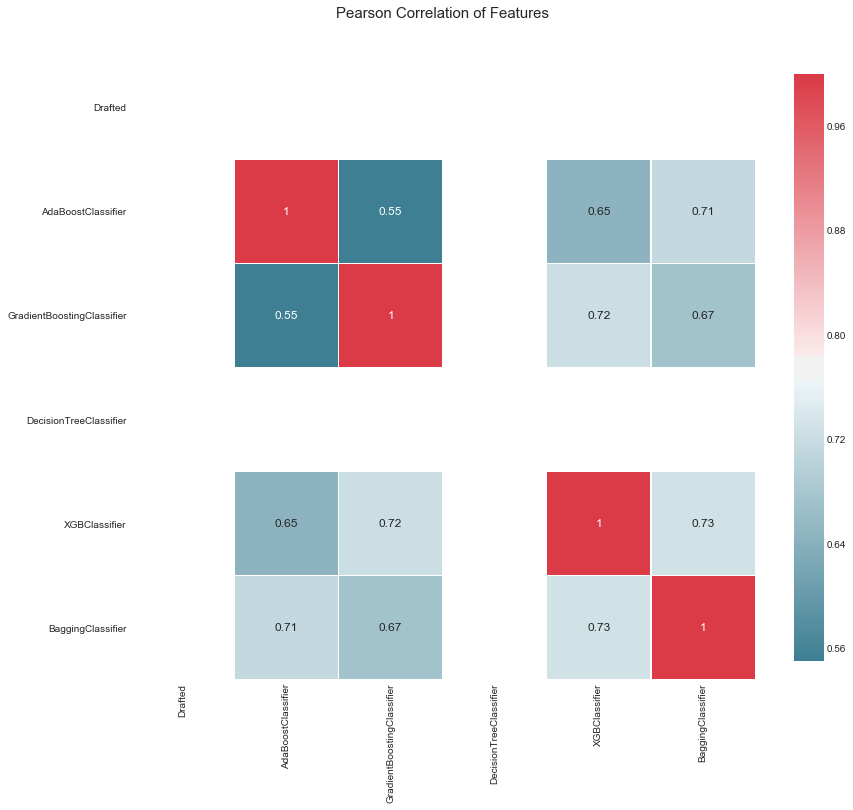

In [50]:
#correlation heatmap of dataset
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(drafted_predict)

In [48]:
new_x = ['age_GP', 'age_GS', 'age_MIN', 'age_FG%', 'age_FT%' ,'age_AST%', 'age_BLK%',
 'age_DRB%', 'age_DRtg', 'age_ORtg', 'age_PER', 'age_PPR', 'age_STL%', 'age_TOV%',
 'age_TRB%', 'age_Total S %', 'age_FGM_per100poss', 'age_FTM_per100poss',
 'age_OFF_per100poss', 'age_DEF_per100poss', 'age_TRB_per100poss',
 'age_AST_per100poss', 'age_BLK_per100poss', 'age_PF_per100poss',
 'age_TOV_per100poss', 'age_PTS_per100poss', 'Height', 'Age', 'inv_RSCI',
 'Pos_B', 'Pos_W']

cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) 

vote_est = [
    ('ada', ensemble.AdaBoostClassifier(n_estimators=80)),
    ('bc', ensemble.BaggingClassifier(base_estimator=ensemble.GradientBoostingClassifier(), n_estimators=25)),
    ('xgb', XGBClassifier(max_depth=3, n_estimators=250))
  
]

#Hard Vote or majority rules
vote_hard = ensemble.VotingClassifier(estimators = vote_est , voting = 'hard')
vote_hard_cv = model_selection.cross_validate(vote_hard, df[new_x], df[target], cv=cv_split, n_jobs=-1)
vote_hard.fit(df[new_x], df[target])

print("Hard Voting Training w/bin score mean: {:.2f}". format(vote_hard_cv['train_score'].mean()*100)) 
print("Hard Voting Test w/bin score mean: {:.2f}". format(vote_hard_cv['test_score'].mean()*100))
print("Hard Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_hard_cv['test_score'].std()*100*3))
print('-'*10)

Hard Voting Training w/bin score mean: 98.46
Hard Voting Test w/bin score mean: 97.65
Hard Voting Test w/bin score 3*std: +/- 0.28
----------


In [42]:
#Soft Vote or weighted probabilities
vote_soft = ensemble.VotingClassifier(estimators = vote_est , voting = 'soft')
vote_soft_cv = model_selection.cross_validate(vote_soft, df[new_x], df[target], cv=cv_split, scoring='recall', n_jobs=-1)
vote_soft.fit(df[new_x], df[target])

print("Soft Voting Training w/bin score mean: {:.2f}". format(vote_soft_cv['train_score'].mean()*100)) 
print("Soft Voting Test w/bin score mean: {:.2f}". format(vote_soft_cv['test_score'].mean()*100))
print("Soft Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_soft_cv['test_score'].std()*100*3))
print('-'*10)

Soft Voting Training w/bin score mean: 60.93
Soft Voting Test w/bin score mean: 41.82
Soft Voting Test w/bin score 3*std: +/- 5.90
----------


In [49]:
# Model selection process with cross validation.
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) 
# run model 10x with 60/30 split intentionally leaving out 10%

#base model
ada = ensemble.AdaBoostClassifier(n_estimators=80)
base_results = model_selection.cross_validate(ada, df[x], df[target], cv=cv_split, scoring='recall', n_jobs=-1)
ada.fit(df[x], df[target])

print('BEFORE DT Parameters: ', ada.get_params())
print("BEFORE DT Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE DT Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE DT Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
print("BEFORE DT Test w/bin set score min: {:.2f}". format(base_results['test_score'].min()*100))
print('-'*10)

BEFORE DT Parameters:  {'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 1.0, 'n_estimators': 80, 'random_state': None}
BEFORE DT Training w/bin score mean: 97.80
BEFORE DT Test w/bin score mean: 97.47
BEFORE DT Test w/bin score 3*std: +/- 0.39
BEFORE DT Test w/bin set score min: 97.25
----------


In [50]:
# Model selection process with cross validation.
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) 
# run model 10x with 60/30 split intentionally leaving out 10%

#base model
ada = ensemble.AdaBoostClassifier(n_estimators=80)
base_results = model_selection.cross_validate(ada, df[x], df[target], cv=cv_split, scoring='recall', n_jobs=-1)
ada.fit(df[x], df[target])

print('BEFORE DT Parameters: ', ada.get_params())
print("BEFORE DT Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE DT Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE DT Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
print("BEFORE DT Test w/bin set score min: {:.2f}". format(base_results['test_score'].min()*100))
print('-'*10)

(25975, 44)

In [51]:
df.to_csv('Age_Pace_adjusted_College_data.csv')